In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl

def makePRCPlot(pred,true,noSkill=True):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label="prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)


In [2]:
#importlib.reload(PeakDetective)

In [3]:
datadir = "../data/covid_plasma/"
resolution = 60
window = 1.0

In [4]:
ms1ppm = 25.5
peakWidth = (13.8,114.6)
s2n = 13.6
noise = 1
mzDiff = 0.0144
prefilter = 5
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
peakList["rt"] = .5 * peakList["rt_start"] + .5 * peakList["rt_end"]
peakList = peakList[["mz","rt"]]
peakList

mz         rt
1       52.995274   5.074233
2       54.977012   5.074233
3       55.018832   6.038233
4       56.995900  13.087117
5       57.034581   1.584267
...           ...        ...
3974  1612.976193  12.735550
3975  1612.974722   2.214650
3976  1613.977307  14.982067
3977  1613.978101   2.214650
3978  1613.978958  12.718933

[3978 rows x 2 columns]

In [5]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [6]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

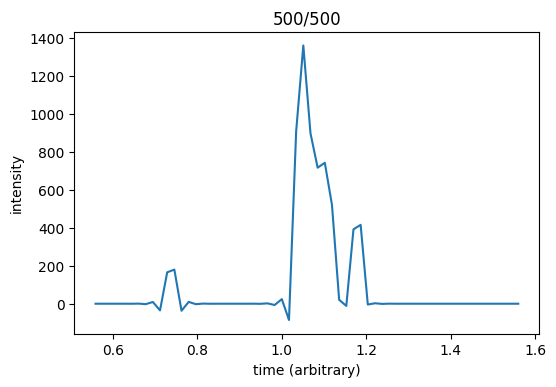

Enter classification (1=True Peak, 0=Artifact): 


 1


In [7]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)
    peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [6]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [8]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts)

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [9]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],rts)
    y_labeled = peakList_labeled["classification"].values
    y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [10]:
X_signal = integ.generateSignalPeaks(peakList,raw_data,n=50)
X_noise = integ.generateFalsePeaks(peakList,raw_data,n=50)
X_syn = np.concatenate((X_signal,X_noise),axis=0)
y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])

forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [11]:
pkl.dump([X,X_labeled,y_labeled,X_syn,y_syn],open("../data/model_selection_data.pkl","wb"))

In [7]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open("../data/model_selection_data.pkl","rb"))

In [12]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,20,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/20
1407/1407 [==============================] - 32s 22ms/step - loss: 0.1569 - mean_absolute_error: 0.0795 - val_loss: 0.0788 - val_mean_absolute_error: 0.0155
Epoch 2/20
1407/1407 [==============================] - 29s 21ms/step - loss: 0.0750 - mean_absolute_error: 0.0133 - val_loss: 0.0730 - val_mean_absolute_error: 0.0111
Epoch 3/20
1407/1407 [==============================] - 31s 22ms/step - loss: 0.0719 - mean_absolute_error: 0.0107 - val_loss: 0.0717 - val_mean_absolute_error: 0.0101
Epoch 4/20
1407/1407 [==============================] - 37s 27ms/step - loss: 0.0709 - mean_absolute_error: 0.0099 - val_loss: 0.0708 - val_mean_absolute_error: 0.0094
Epoch 5/20
1407/1407 [==============================] - 26s 19ms/step - loss: 0.0700 - mean_absolute_error: 0.0094 - val_loss: 0.0701 - val_mean_absolute_error: 0.0089
Epoch 6/20
1407/1407 [==================

In [13]:
valInds = list(range(len(X_labeled)))
valInds = rd.sample(valInds,k=50)

X_val = X_labeled[valInds]
y_val = y_labeled[valInds]

X_labeled = X_labeled[[x for x in range(len(X_labeled)) if x not in valInds]]
y_labeled = y_labeled[[x for x in range(len(y_labeled)) if x not in valInds]]

In [14]:
X_labeled_norm = PeakDetective.normalizeMatrix(X_labeled)
X_labeled_smoothed = integ.smoother.predict(PeakDetective.normalizeMatrix(X_labeled))

15/15 [==============================] - 0s 7ms/step


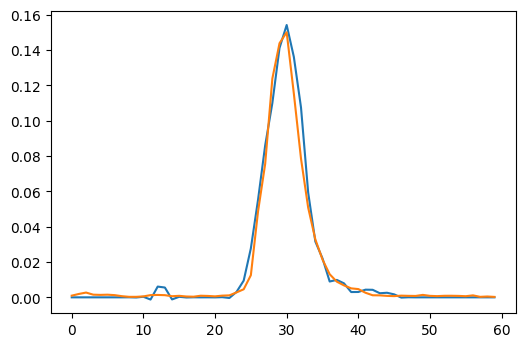

In [15]:
ind = rd.choice(list(range(len(X_labeled))))
plt.plot(X_labeled_norm[ind])
plt.plot(X_labeled_smoothed[ind])

In [16]:
if __name__ == "__main__":
    integ.trainClassifier(X_labeled,y_labeled,X_val,y_val,1000,32,5)

2/2 [==============================] - 0s 10ms/step
loss: 0.5962209701538086 mean_absolute_error: 0.38957032561302185 val loss: 0.5474621057510376 val_mean_absolute_error: 0.356578528881073 numEpochs: 374


In [17]:
y_val_scores_supervised = integ.classifyMatrix(X_val)

2/2 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 24ms/step
loss: 0.5653663277626038 mean_absolute_error: 0.3478715717792511 val loss: 0.6474102139472961 val_mean_absolute_error: 0.4378827214241028 numEpochs: 137
371/371 [==============================] - 1s 1ms/step


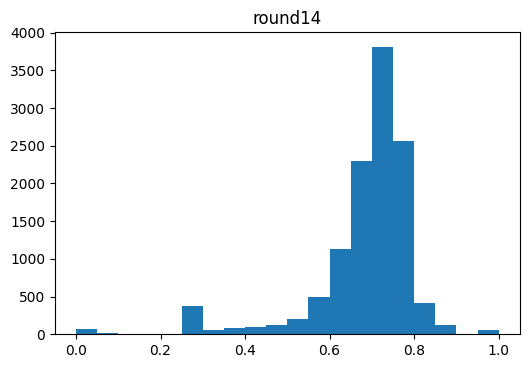

11854 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


In [18]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,X_syn,y_syn,1000,32,5,numVal = 10,numManualPerRound=5,inJupyter=True)

In [19]:
y_val_scores_active = integ.classifyMatrix(X_val)

2/2 [==============================] - 0s 3ms/step


0.7518

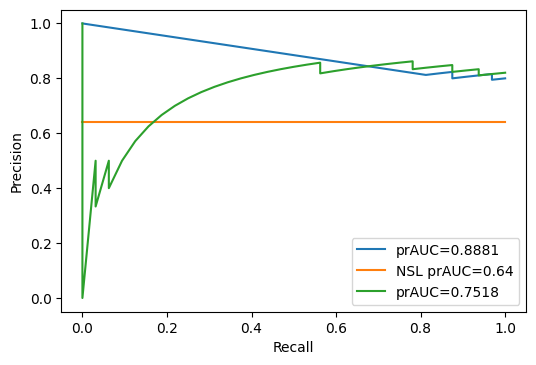

In [20]:
makePRCPlot(y_val_scores_supervised[:,1],y_val[:,1],noSkill=True)
makePRCPlot(y_val_scores_active[:,1],y_val[:,1],noSkill=False)

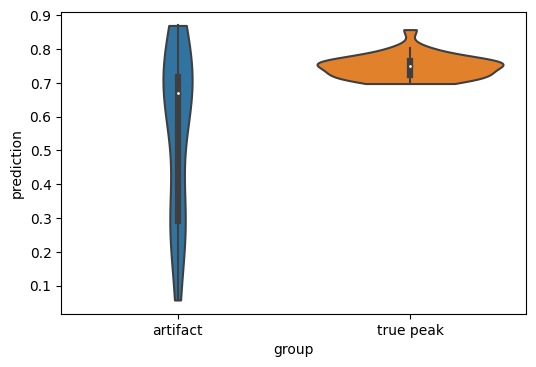

In [21]:
makeViolinPlot(y_val_scores_active[:,1],y_val[:,1])

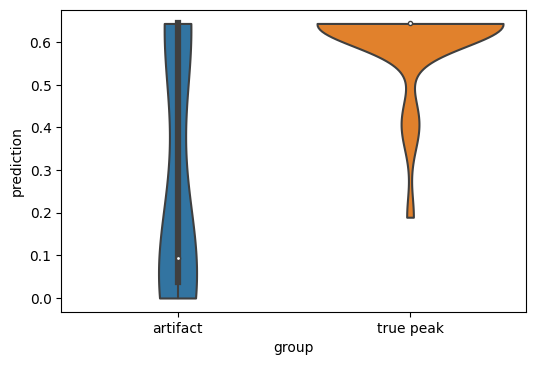

In [22]:
makeViolinPlot(y_val_scores_supervised[:,1],y_val[:,1])

In [23]:
pkl.dump(integ,open(datadir + "PeakDetective.pkl","wb"))

INFO:tensorflow:Assets written to: ram://4ff11dad-5ff9-4c62-ab97-fc04f738ae0f/assets


INFO:tensorflow:Assets written to: ram://4ff11dad-5ff9-4c62-ab97-fc04f738ae0f/assets


INFO:tensorflow:Assets written to: ram://b28976d8-86fd-4a30-afa6-d347cbff1e9a/assets


INFO:tensorflow:Assets written to: ram://b28976d8-86fd-4a30-afa6-d347cbff1e9a/assets


INFO:tensorflow:Assets written to: ram://e1bd80d8-0a1c-4519-a68e-3d1d09d0b39a/assets


INFO:tensorflow:Assets written to: ram://e1bd80d8-0a1c-4519-a68e-3d1d09d0b39a/assets


In [24]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=0.5)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
373/373 [==============================] - 1s 2ms/step


In [25]:
y = integ.classifyMatrix(X)

373/373 [==============================] - 1s 1ms/step


In [26]:
peak_curated

mz         rt  ../data/covid_plasma/B1_NIST1950_1_6540.mzML  \
1       52.995274   5.074233                                           0.0   
2       54.977012   5.074233                                           1.0   
3       55.018832   6.038233                                           1.0   
4       56.995900  13.087117                                           1.0   
5       57.034581   1.584267                                           1.0   
...           ...        ...                                           ...   
3974  1612.976193  12.735550                                           1.0   
3975  1612.974722   2.214650                                           1.0   
3976  1613.977307  14.982067                                           1.0   
3977  1613.978101   2.214650                                           0.0   
3978  1613.978958  12.718933                                           1.0   

      ../data/covid_plasma/B1_NIST1950_2_6540.mzML  \
1                                              0.0   
2                                              1.0   
3                                              1.0   
4                                              1.0   
5                                              1.0   
...                                            ...   
3974                                           1.0   
3975                                           1.0   
3976                                           1.0   
3977                                           1.0   
3978                                           1.0   

      ../data/covid_plasma/B1_NIST1950_3_6540.mzML  
1                                              0.0  
2                                              1.0  
3                                              1.0  
4                                              1.0  
5                                              1.0  
...                                            ...  
3974                                           0.0  
3975                                           1.0  
3976                                           1.0  
3977                                           0.0  
3978                                           1.0  

[3978 rows x 5 columns]

In [27]:
peak_scores

mz         rt  ../data/covid_plasma/B1_NIST1950_1_6540.mzML  \
1       52.995274   5.074233                                      0.294480   
2       54.977012   5.074233                                      0.773839   
3       55.018832   6.038233                                      0.542533   
4       56.995900  13.087117                                      0.829982   
5       57.034581   1.584267                                      0.686179   
...           ...        ...                                           ...   
3974  1612.976193  12.735550                                      0.618193   
3975  1612.974722   2.214650                                      0.642164   
3976  1613.977307  14.982067                                      0.584861   
3977  1613.978101   2.214650                                      0.372467   
3978  1613.978958  12.718933                                      0.599020   

      ../data/covid_plasma/B1_NIST1950_2_6540.mzML  \
1                                         0.294480   
2                                         0.765217   
3                                         0.612723   
4                                         0.825855   
5                                         0.675190   
...                                            ...   
3974                                      0.731141   
3975                                      0.720012   
3976                                      0.690597   
3977                                      0.669544   
3978                                      0.651932   

      ../data/covid_plasma/B1_NIST1950_3_6540.mzML  
1                                         0.294480  
2                                         0.762674  
3                                         0.638189  
4                                         0.825860  
5                                         0.648408  
...                                            ...  
3974                                      0.293224  
3975                                      0.655387  
3976                                      0.623082  
3977                                      0.294703  
3978                                      0.599538  

[3978 rows x 5 columns]

In [28]:
peak_intensities

mz         rt  ../data/covid_plasma/B1_NIST1950_1_6540.mzML  \
1       52.995274   5.074233                                  0.000000e+00   
2       54.977012   5.074233                                  1.379597e+05   
3       55.018832   6.038233                                  2.614126e+03   
4       56.995900  13.087117                                  5.008748e+06   
5       57.034581   1.584267                                  1.841325e+04   
...           ...        ...                                           ...   
3974  1612.976193  12.735550                                  8.198740e+03   
3975  1612.974722   2.214650                                  1.181902e+04   
3976  1613.977307  14.982067                                  2.652394e+03   
3977  1613.978101   2.214650                                  2.456033e+02   
3978  1613.978958  12.718933                                  5.738912e+03   

      ../data/covid_plasma/B1_NIST1950_2_6540.mzML  \
1                                     0.000000e+00   
2                                     1.058572e+05   
3                                     4.649819e+03   
4                                     4.108130e+06   
5                                     1.813873e+04   
...                                            ...   
3974                                  1.054114e+05   
3975                                  6.946844e+04   
3976                                  1.273110e+04   
3977                                  2.527240e+04   
3978                                  1.305602e+04   

      ../data/covid_plasma/B1_NIST1950_3_6540.mzML  
1                                     0.000000e+00  
2                                     1.038218e+05  
3                                     4.437179e+03  
4                                     4.011063e+06  
5                                     1.296935e+04  
...                                            ...  
3974                                 -4.483487e+02  
3975                                  1.512852e+04  
3976                                  4.922531e+03  
3977                                  0.000000e+00  
3978                                  4.779079e+03  

[3978 rows x 5 columns]

In [29]:
peakList

mz         rt
1       52.995274   5.074233
2       54.977012   5.074233
3       55.018832   6.038233
4       56.995900  13.087117
5       57.034581   1.584267
...           ...        ...
3974  1612.976193  12.735550
3975  1612.974722   2.214650
3976  1613.977307  14.982067
3977  1613.978101   2.214650
3978  1613.978958  12.718933

[3978 rows x 2 columns]

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


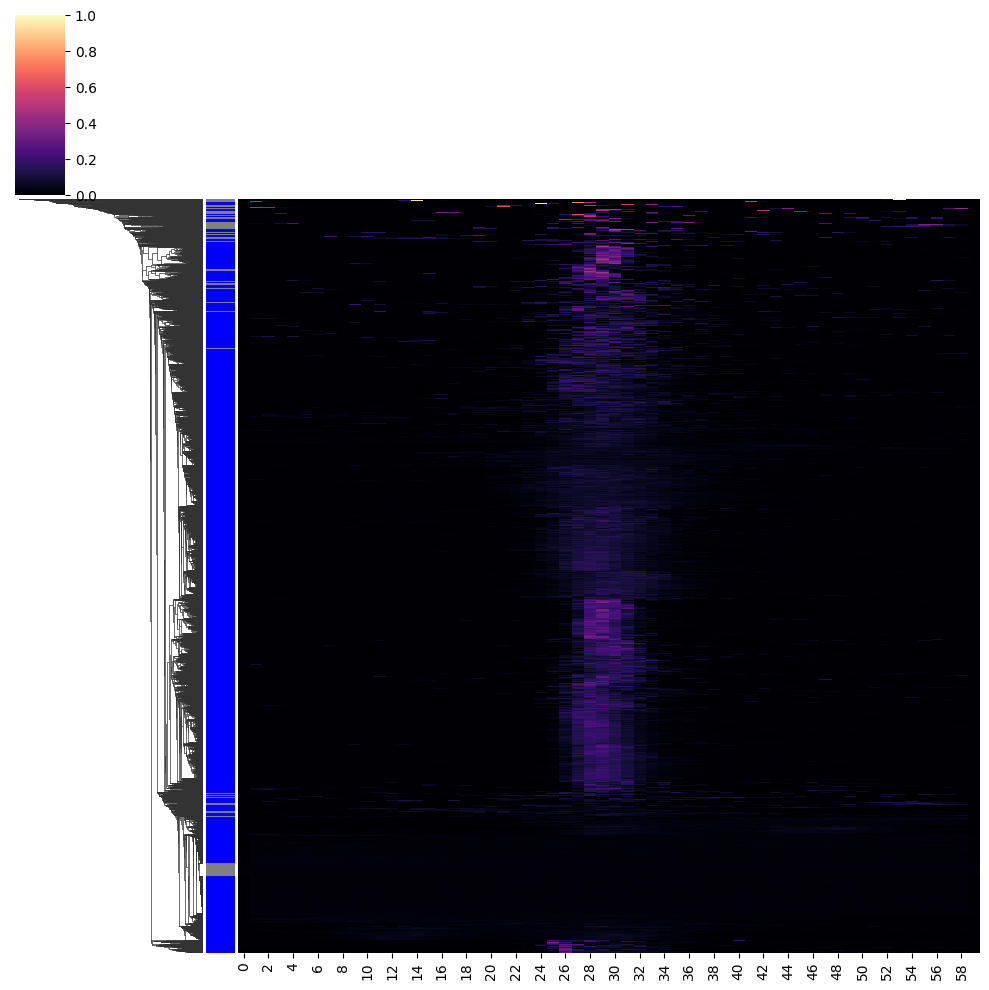

In [30]:
def tmp(val):
    if val > 0.5:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:,1]]
sb.clustermap(PeakDetective.normalizeMatrix(X),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)

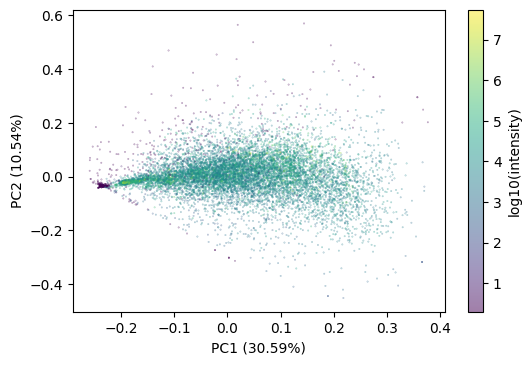

In [31]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

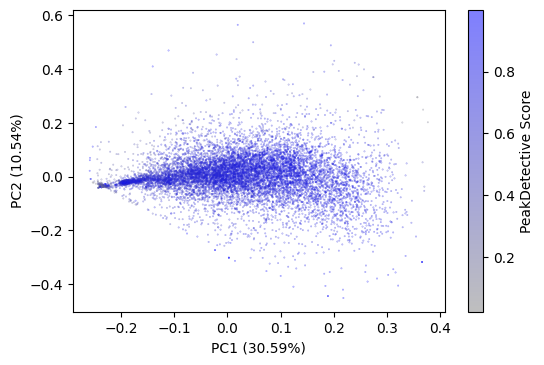

In [32]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="PeakDetective Score")

Text(0, 0.5, '% of features')

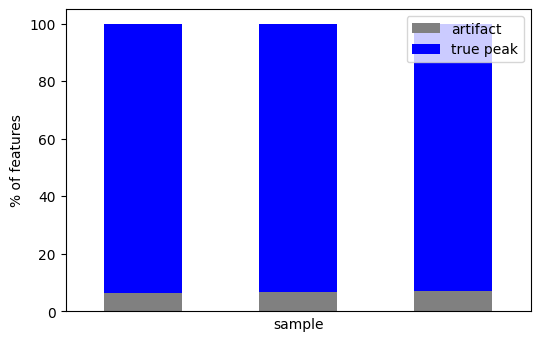

In [33]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > 0.5:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


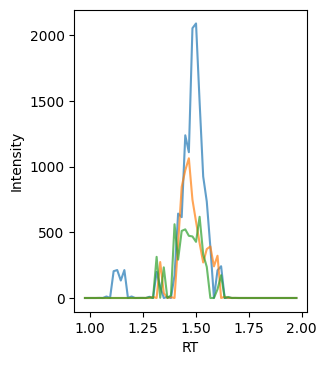

In [34]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

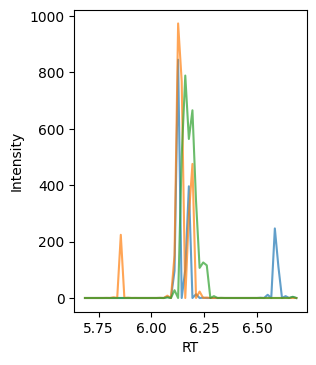

In [35]:
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [36]:
true = []
pred = []
file = files[0]
fps = []
fns = []
for index,row in peakList_labeled.iterrows():
    if peak_curated.at[index,datadir + file] > 0.5:
        pred.append(1.0)
        if row["classification"] < 0.5:
            fps.append(index)
    else:
        pred.append(0.0)
        if row["classification"] > .5:
            fns.append(index)
    true.append(row["classification"])
    
confusion_matrix(true,pred)

array([[ 38, 177],
       [  1, 284]], dtype=int64)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


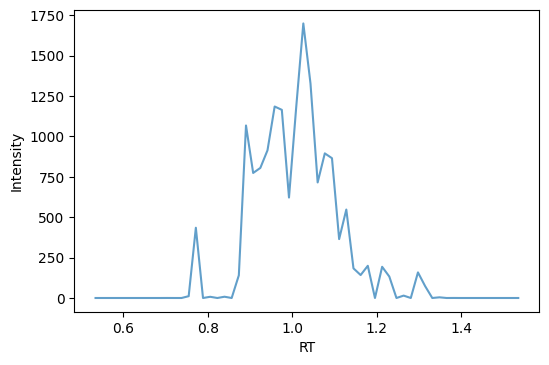

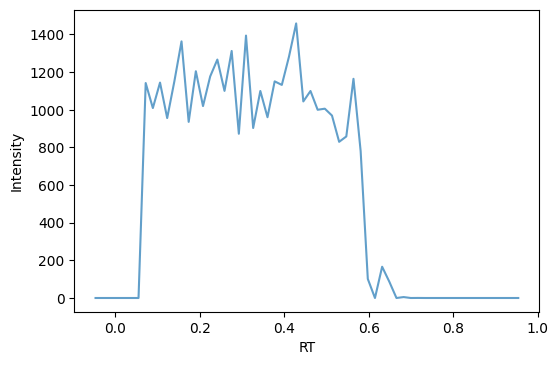

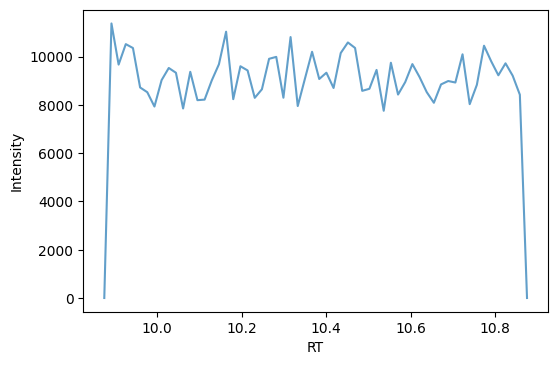

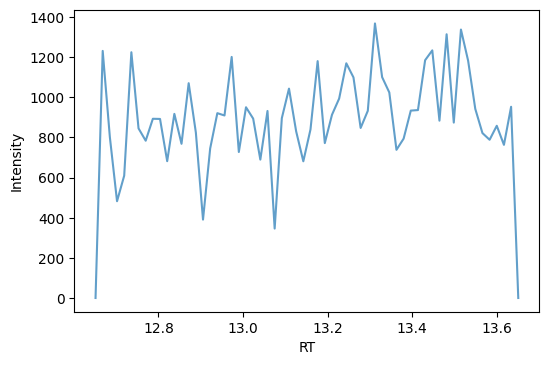

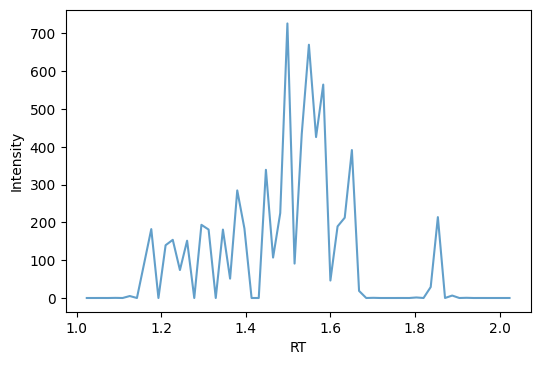

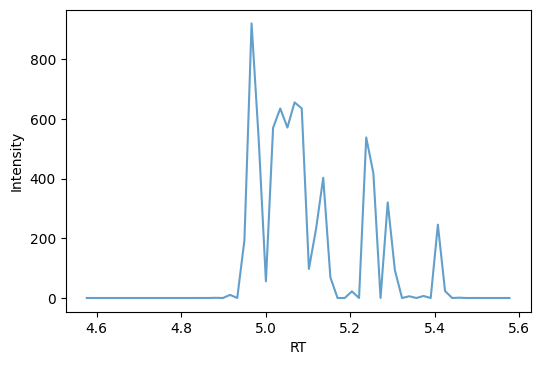

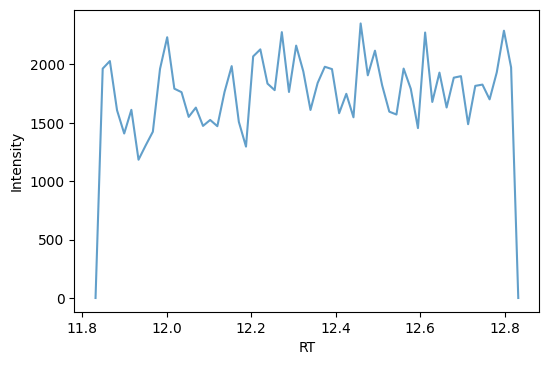

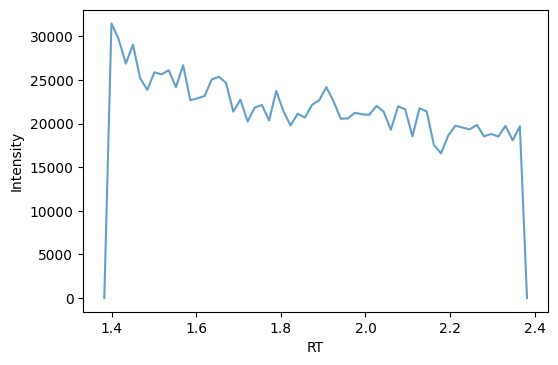

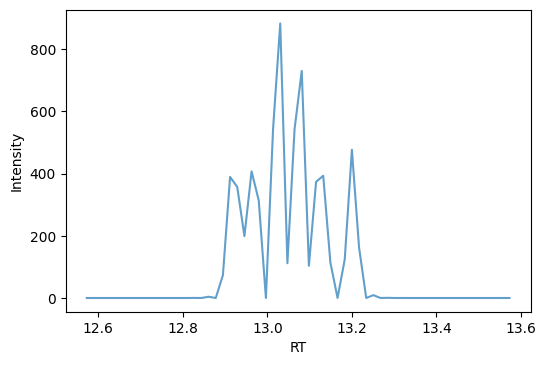

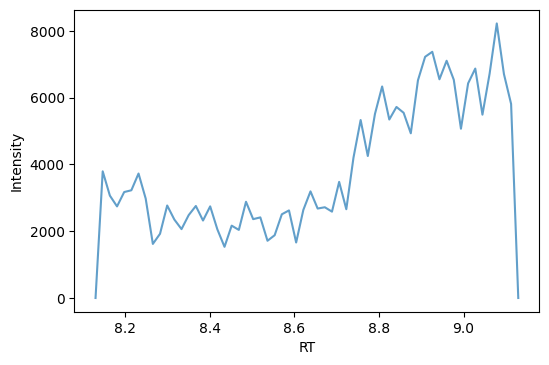

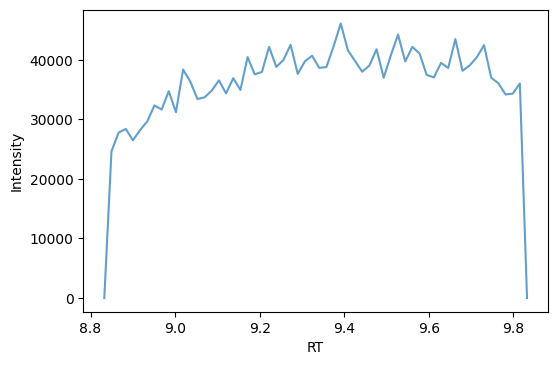

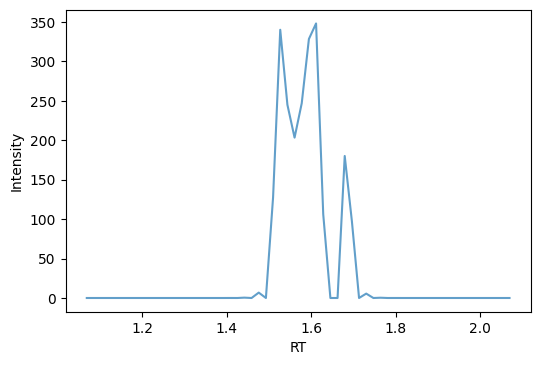

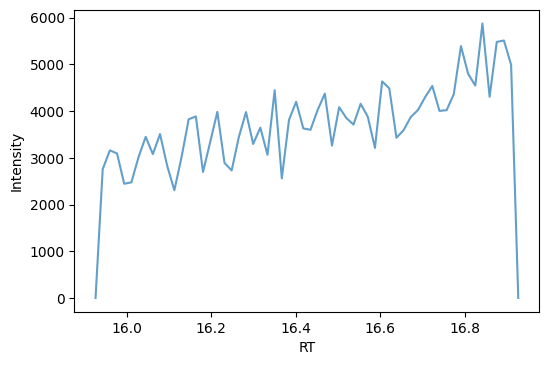

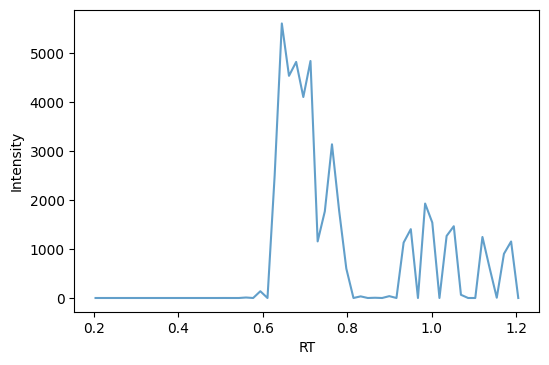

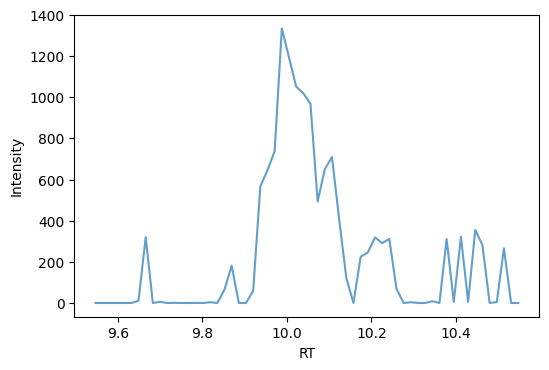

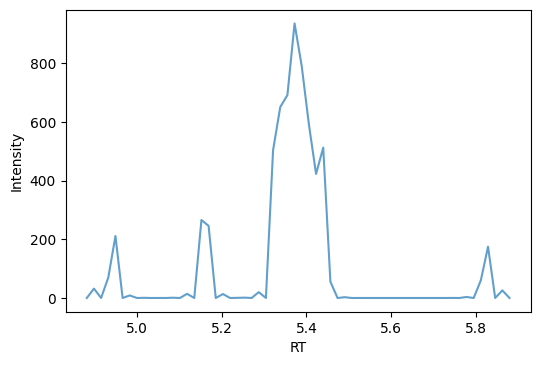

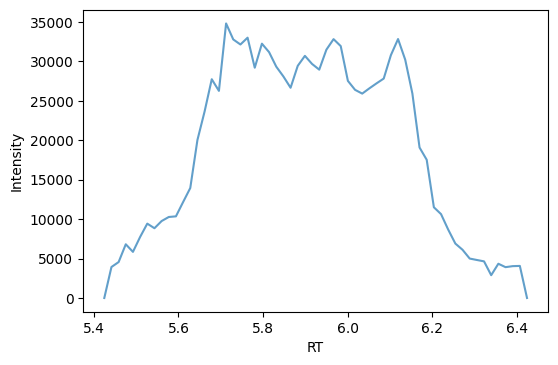

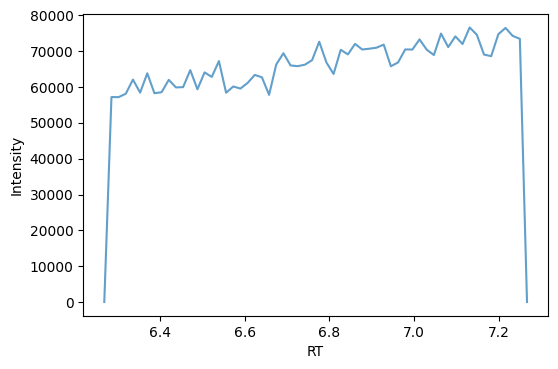

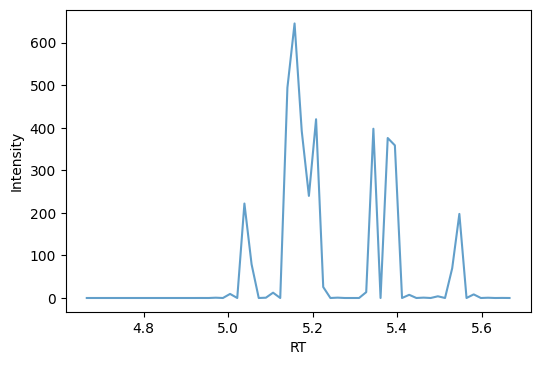

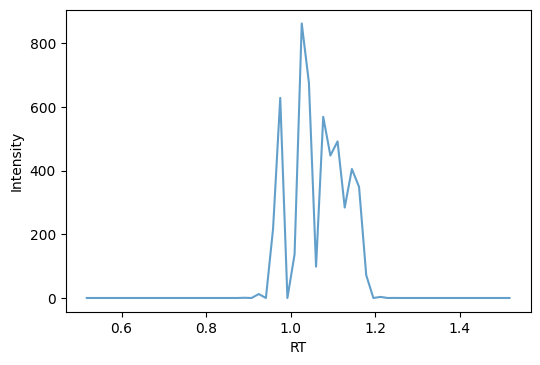

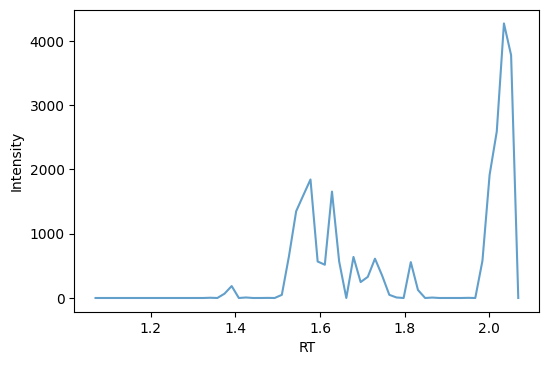

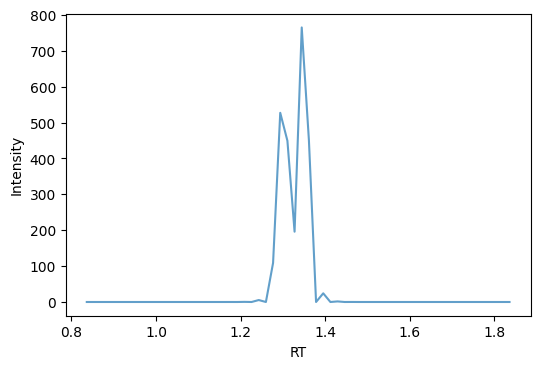

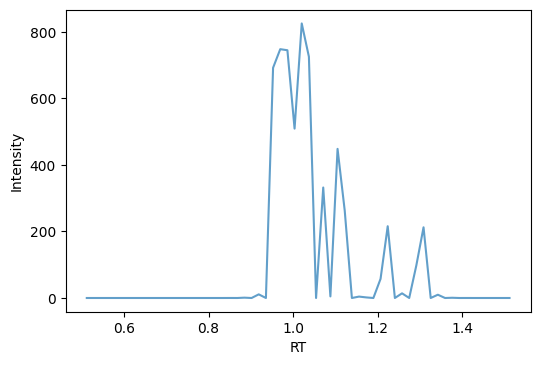

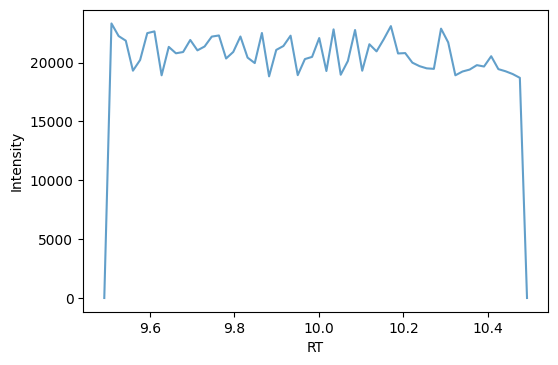

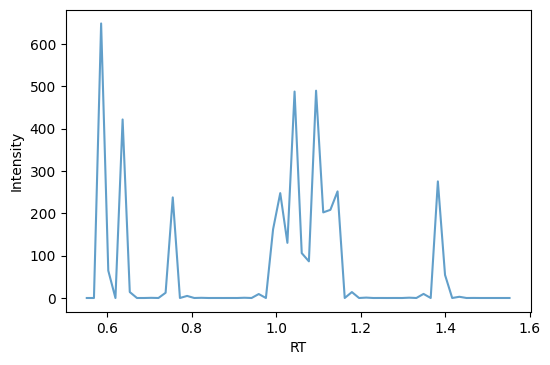

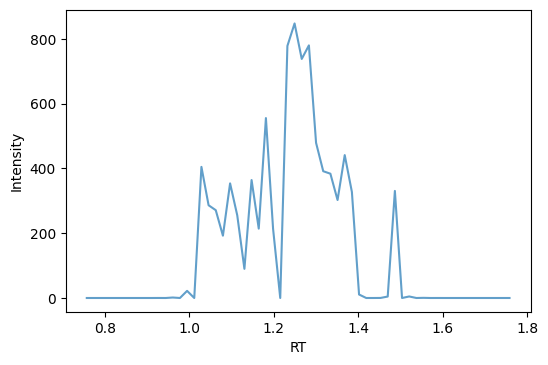

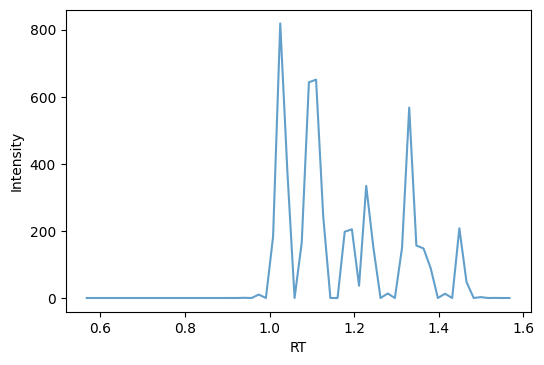

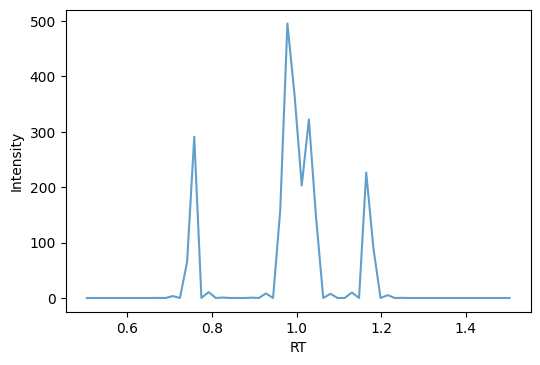

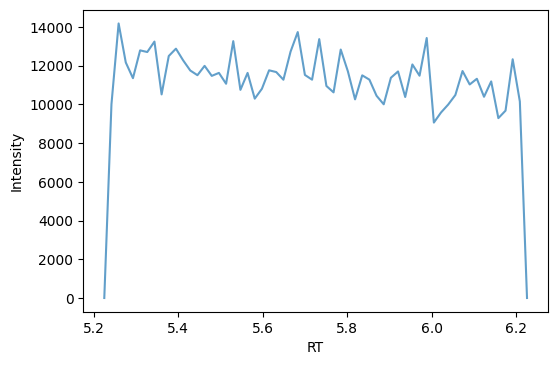

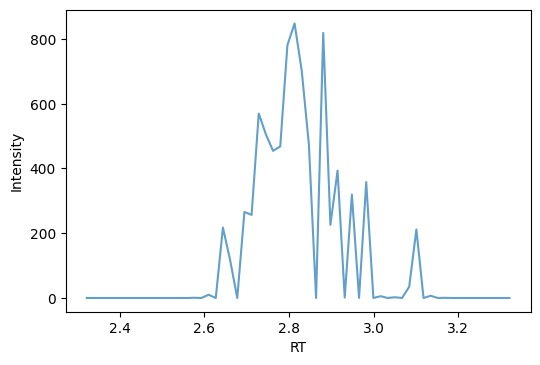

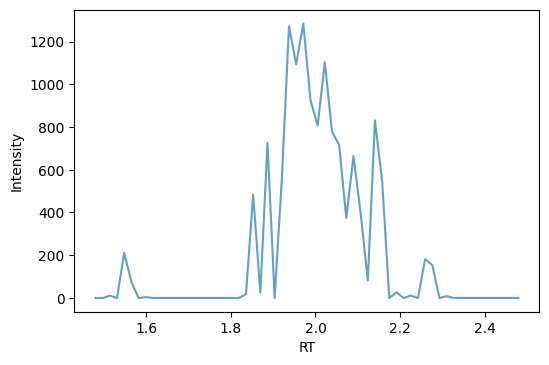

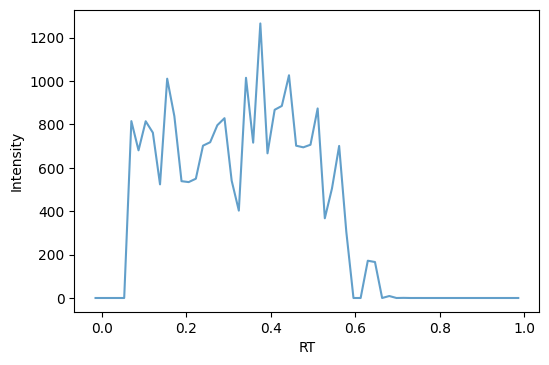

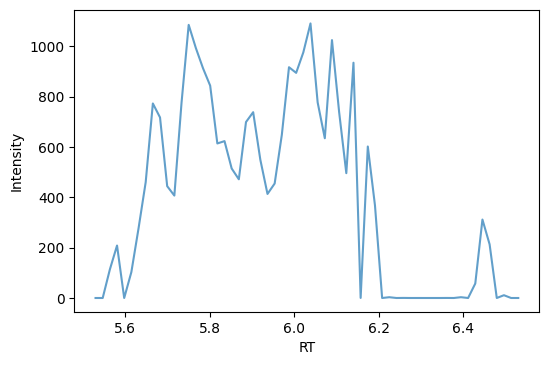

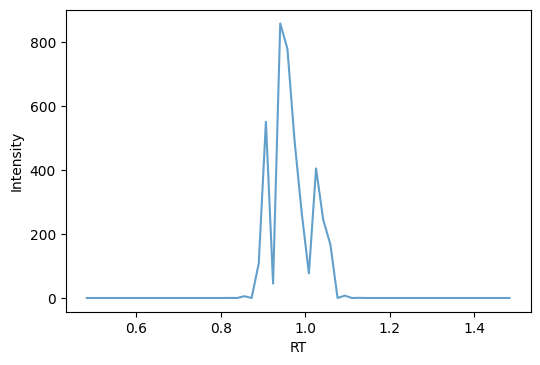

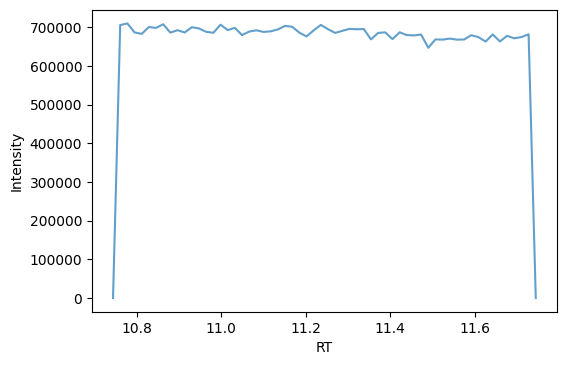

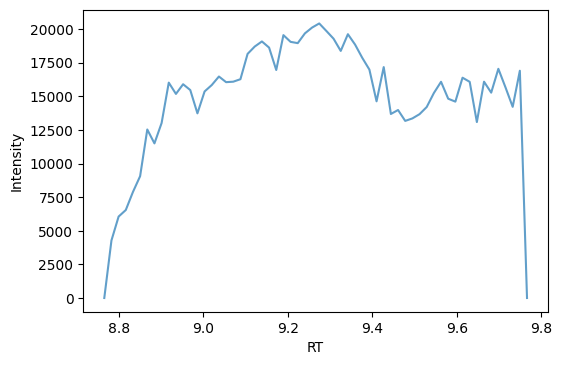

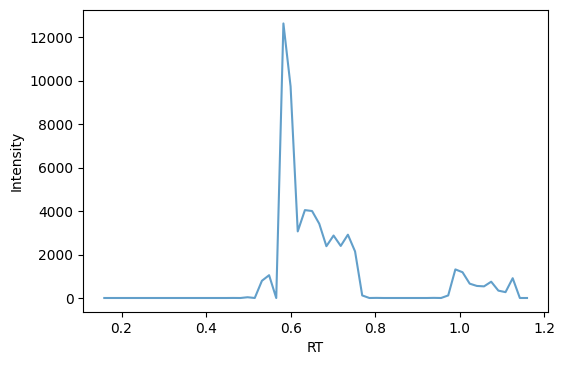

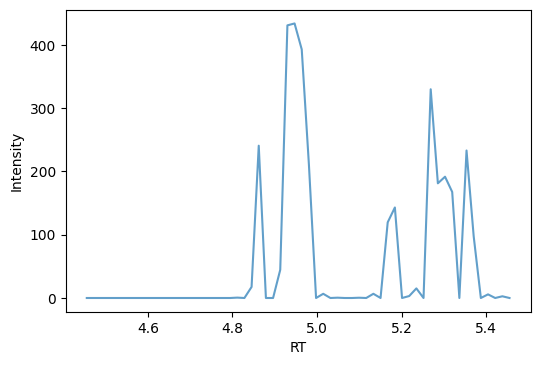

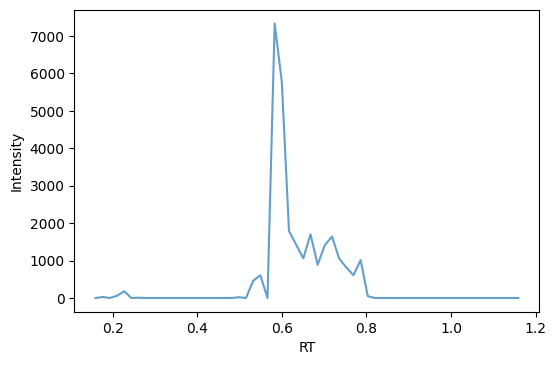

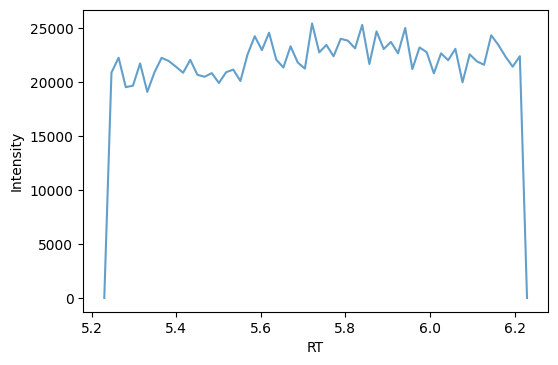

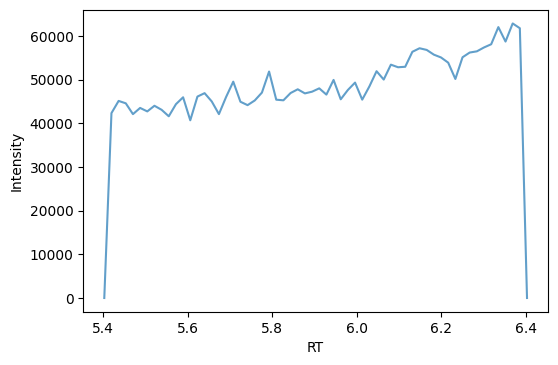

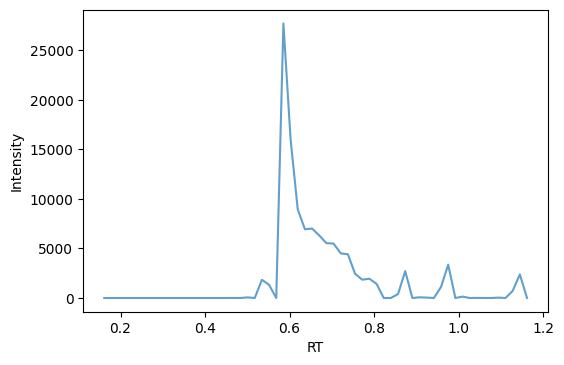

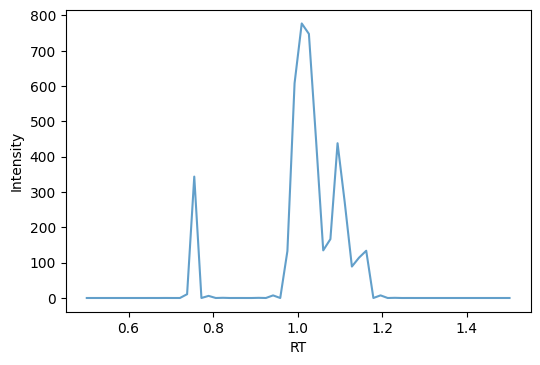

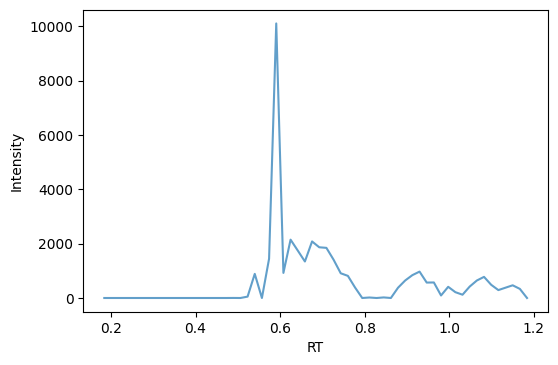

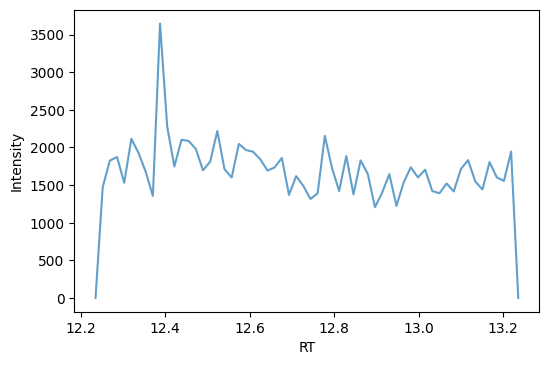

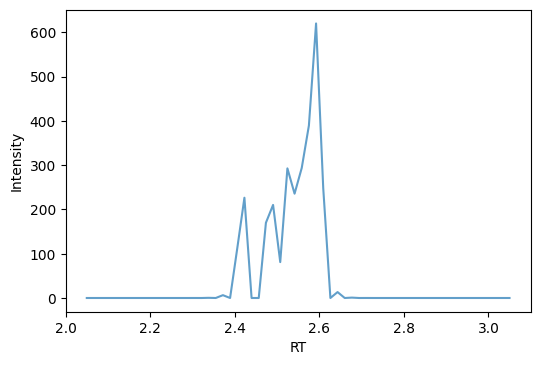

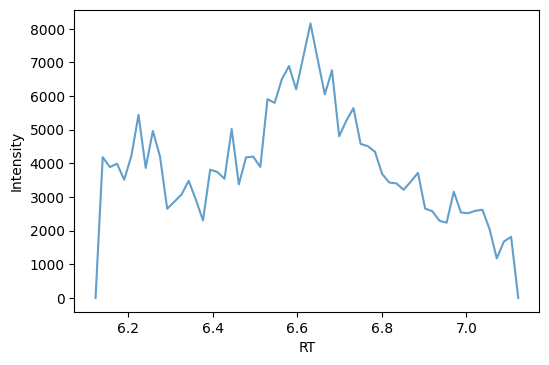

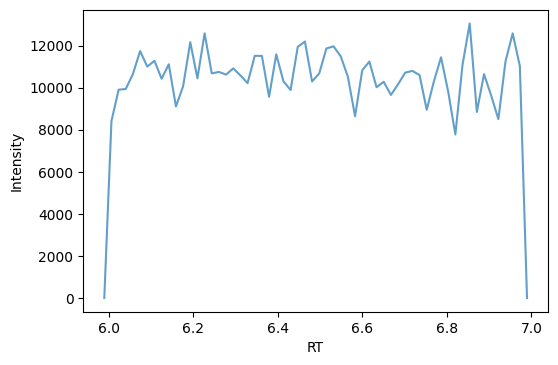

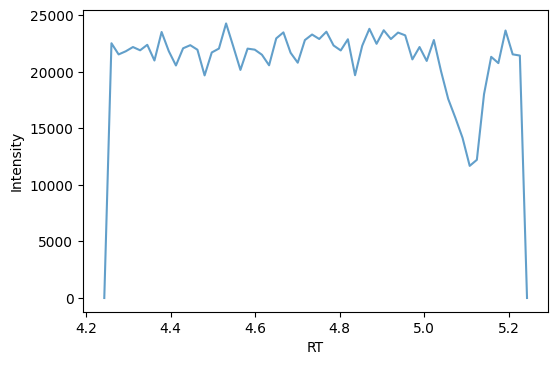

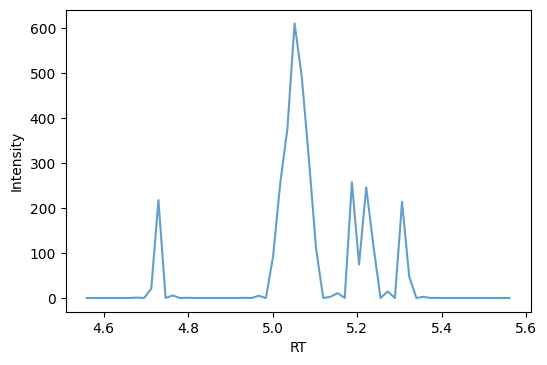

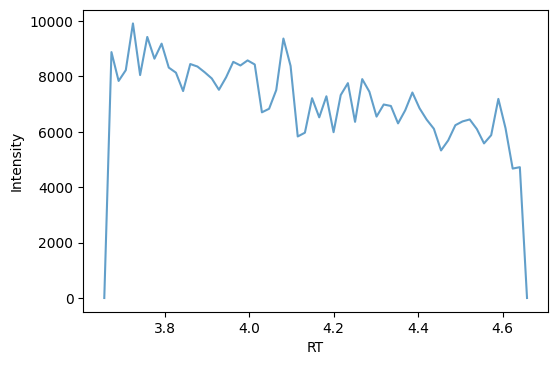

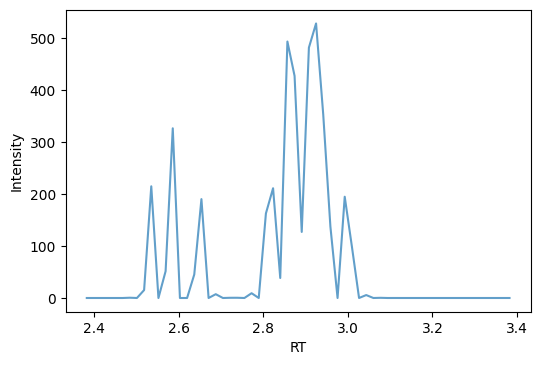

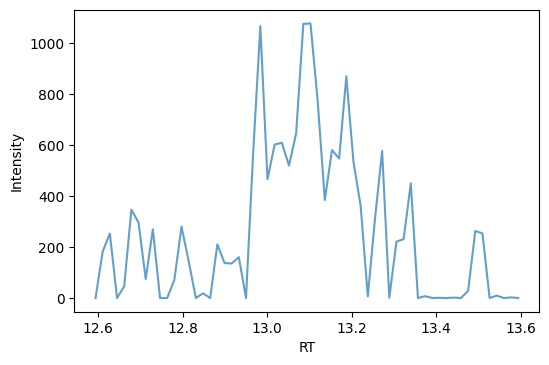

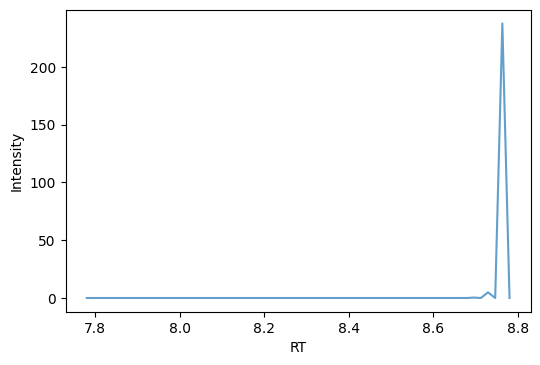

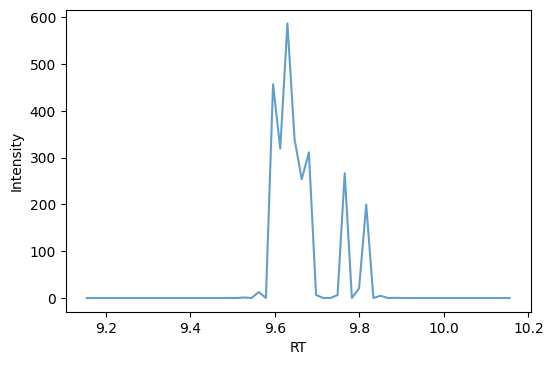

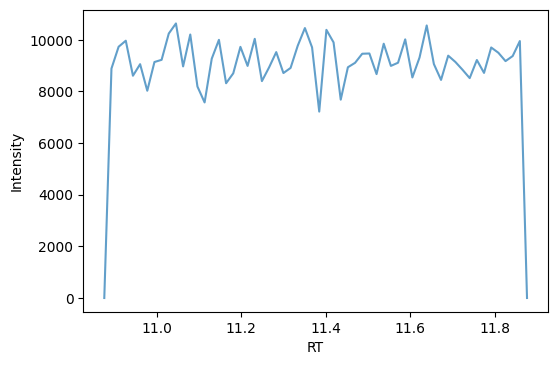

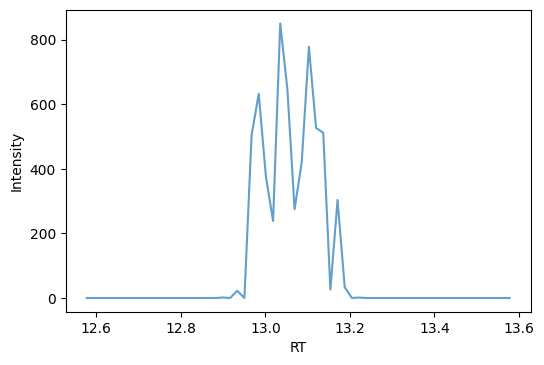

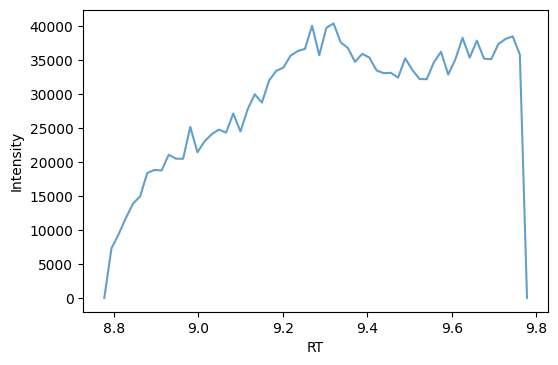

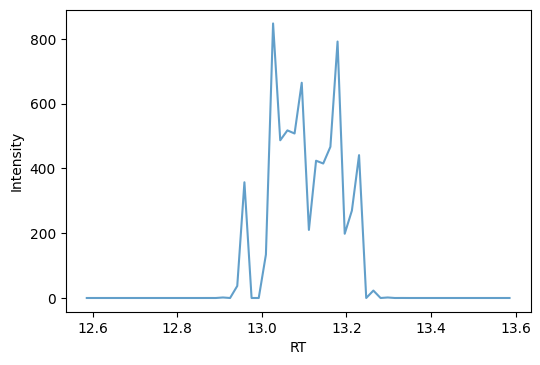

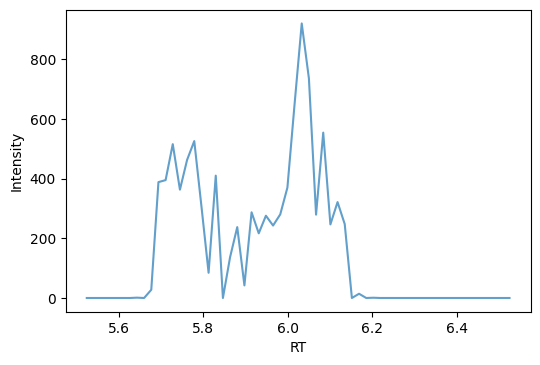

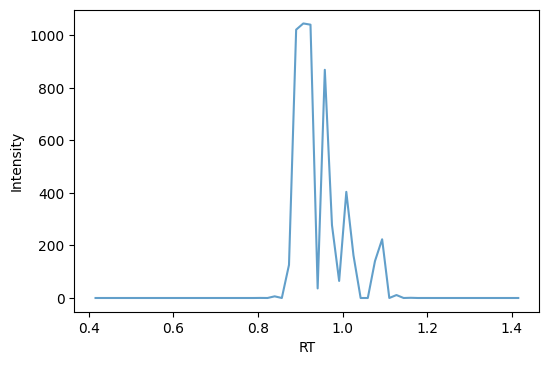

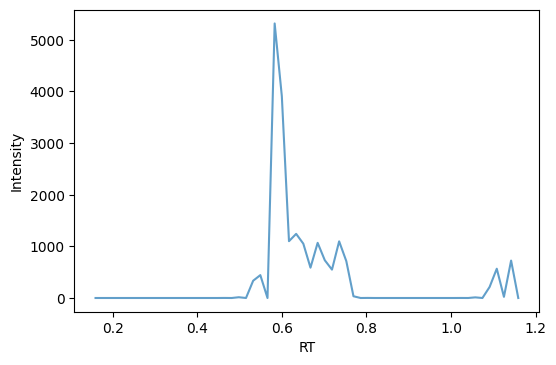

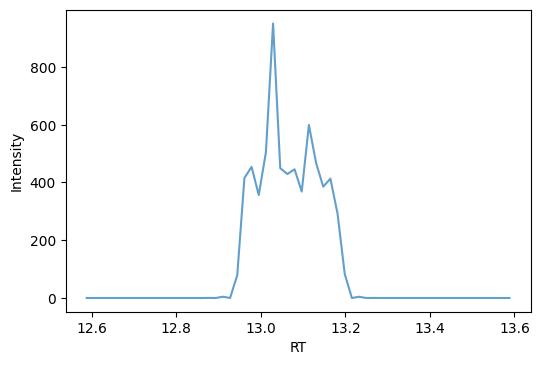

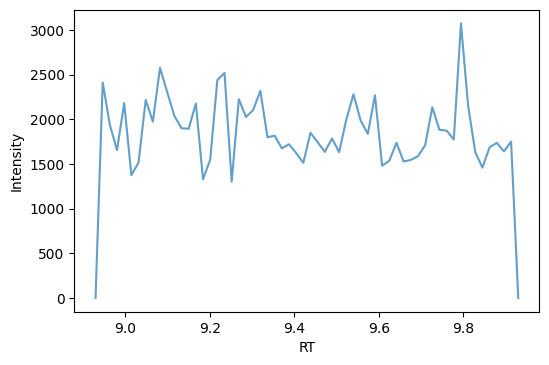

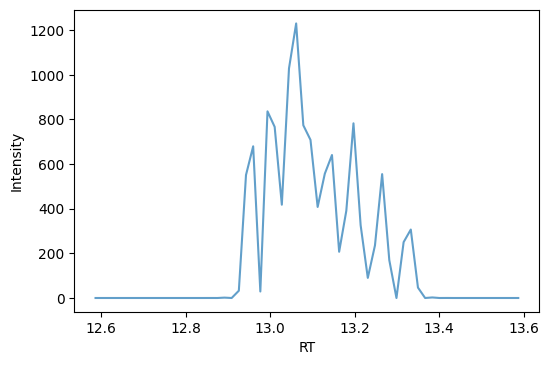

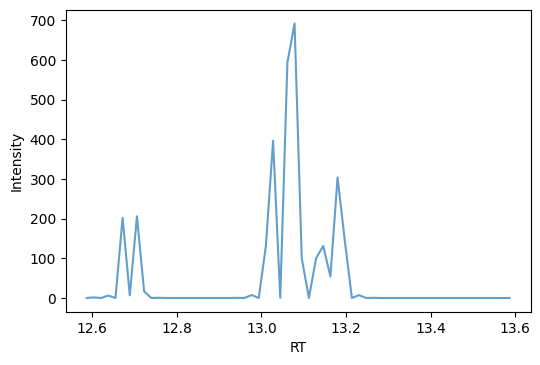

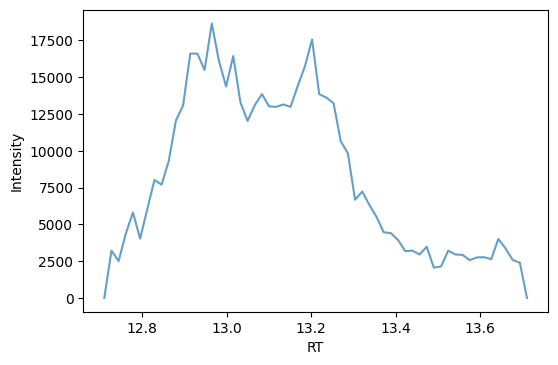

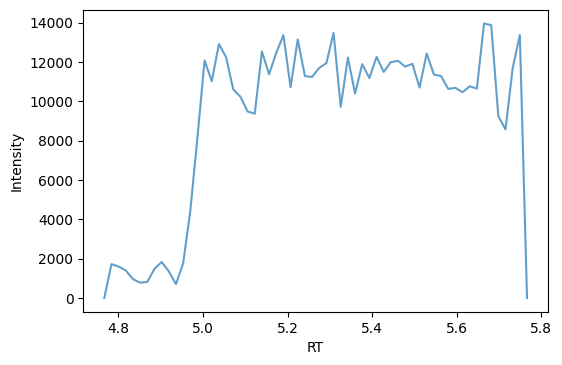

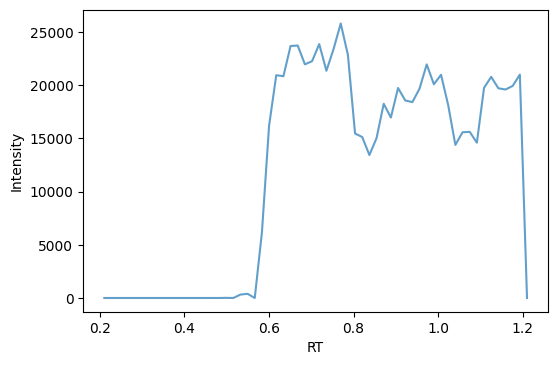

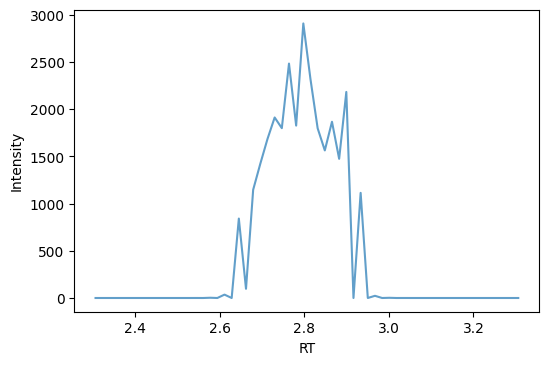

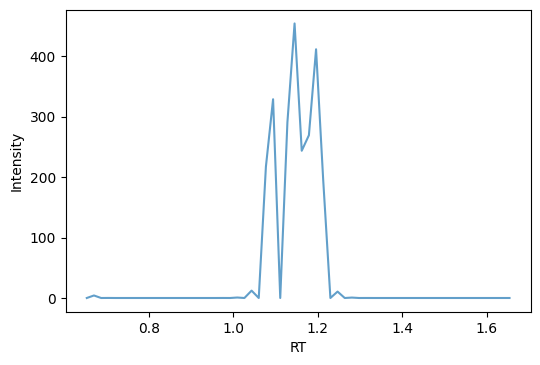

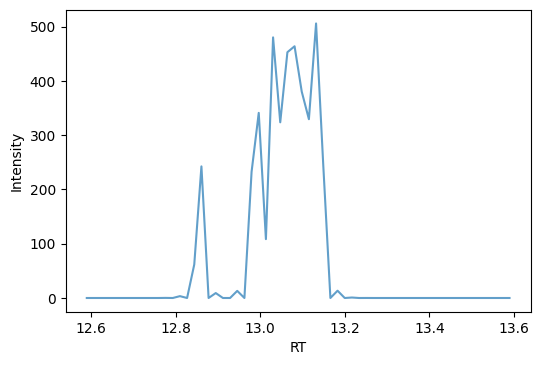

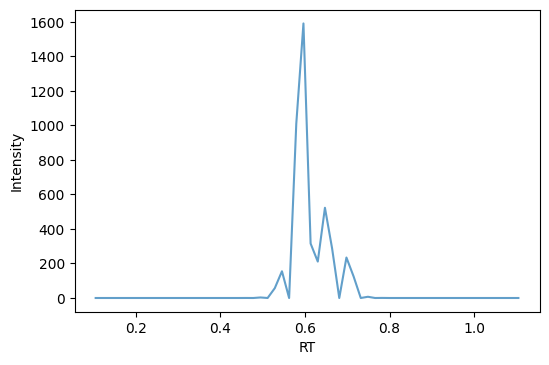

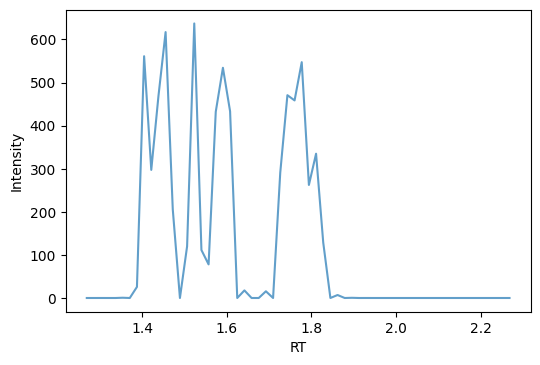

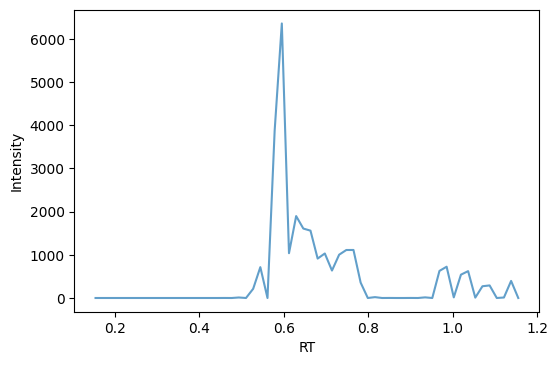

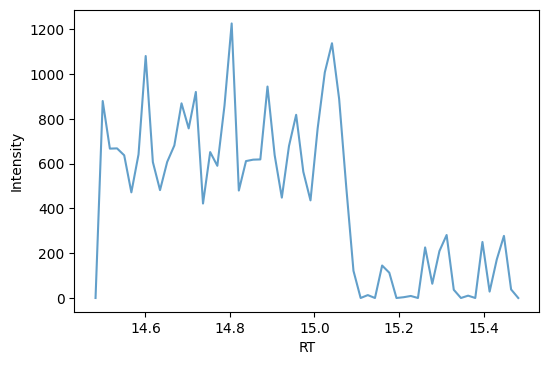

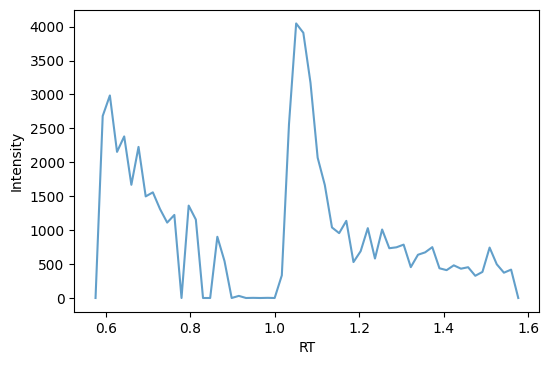

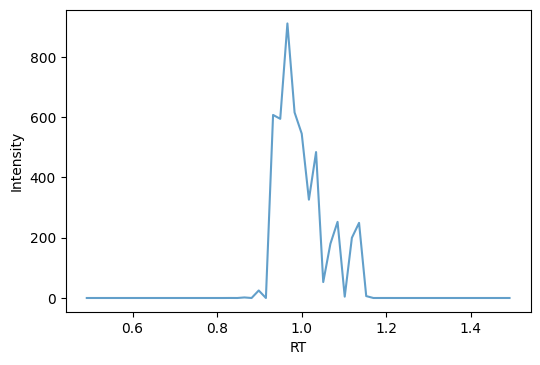

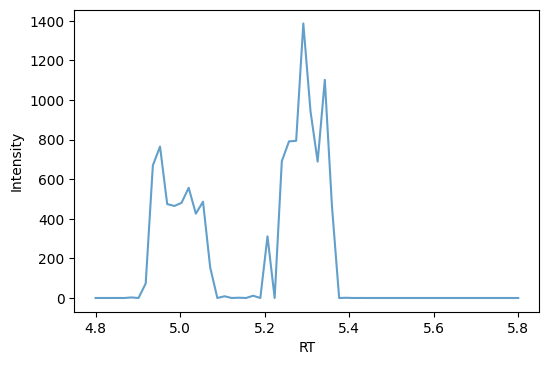

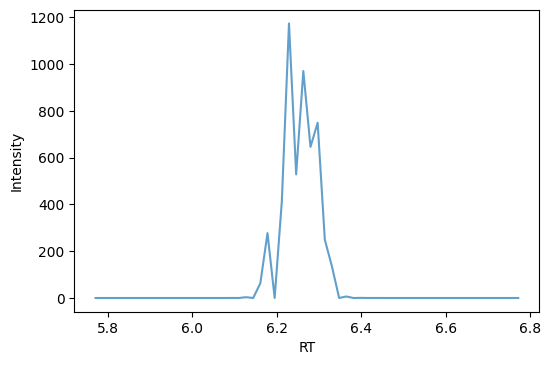

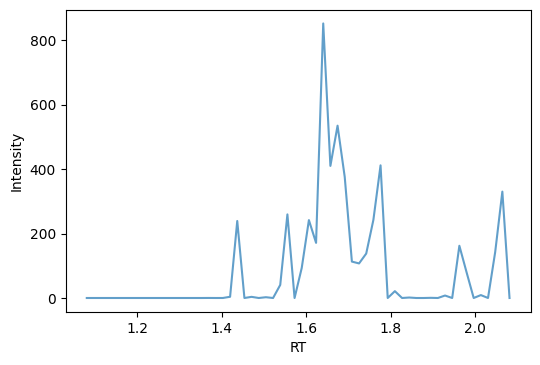

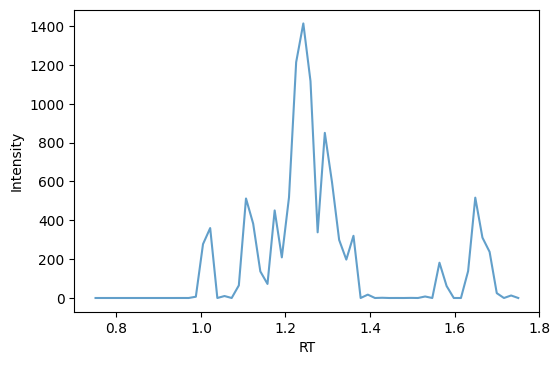

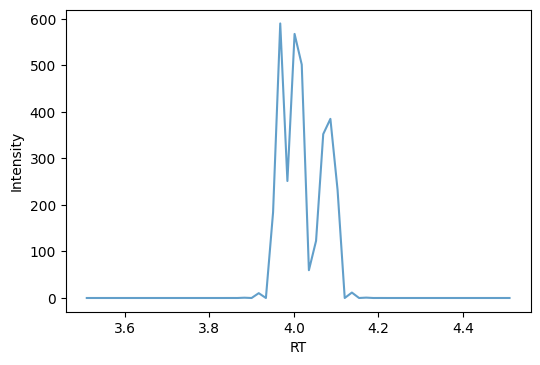

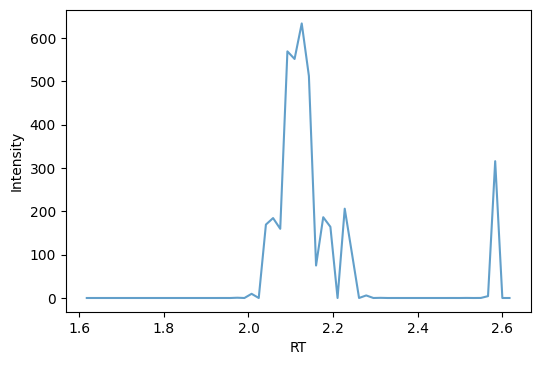

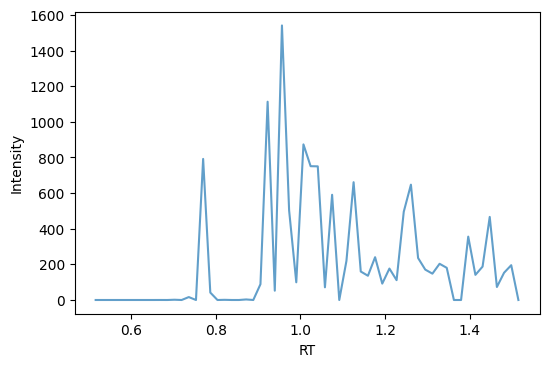

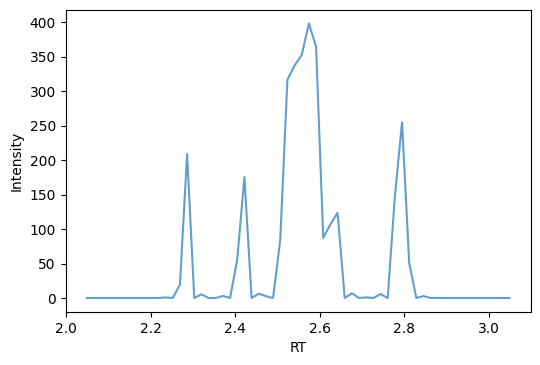

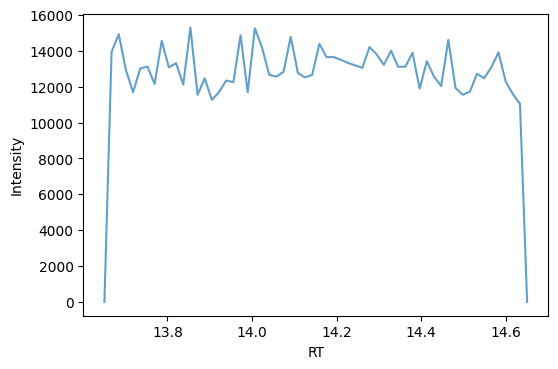

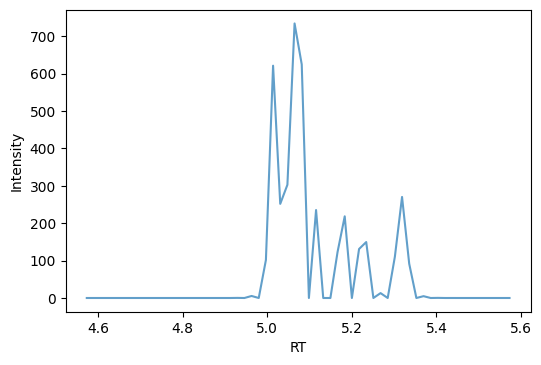

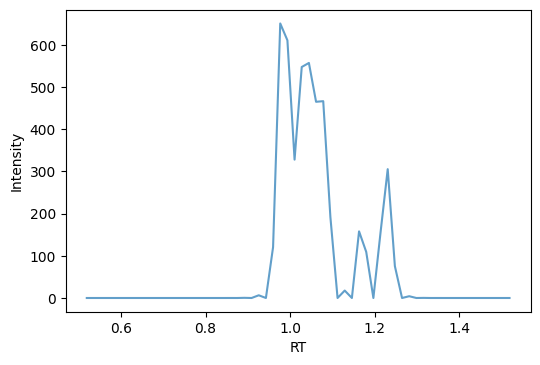

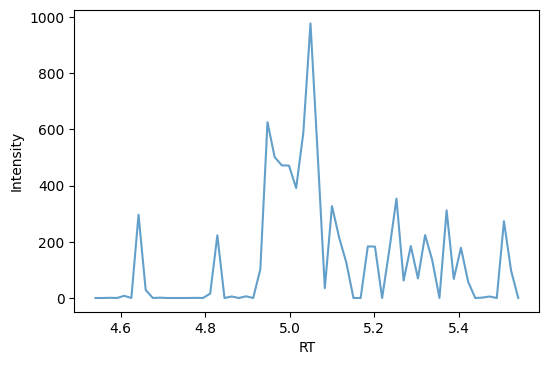

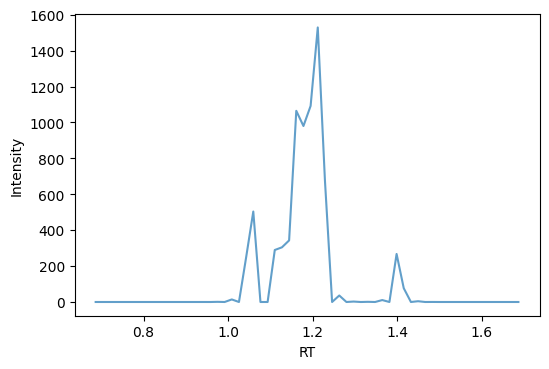

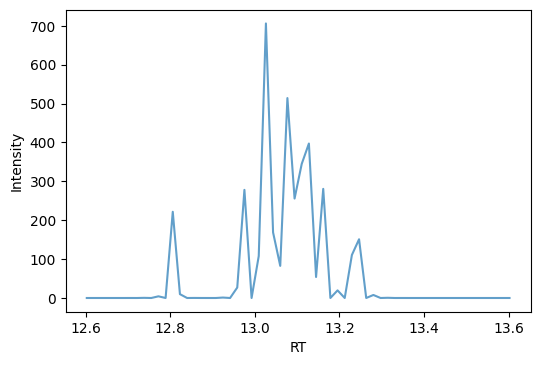

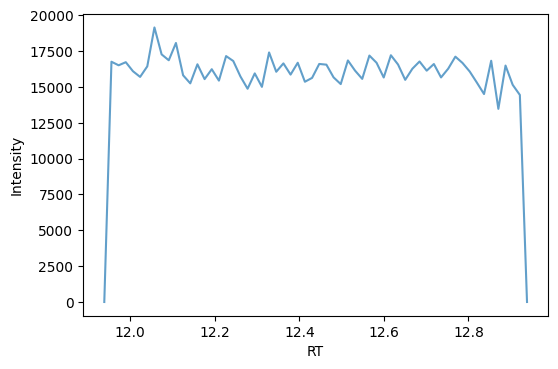

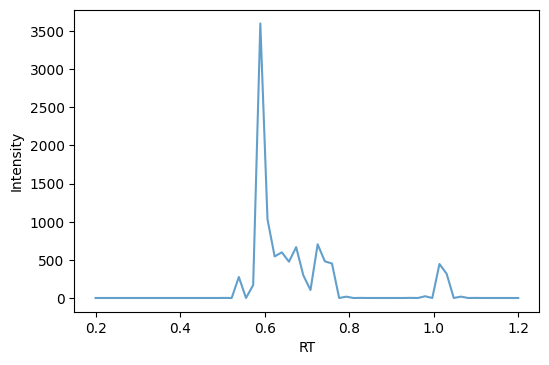

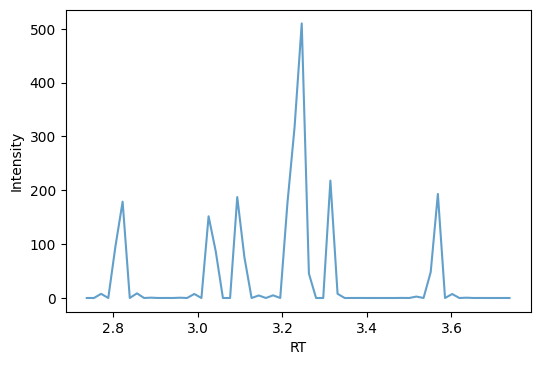

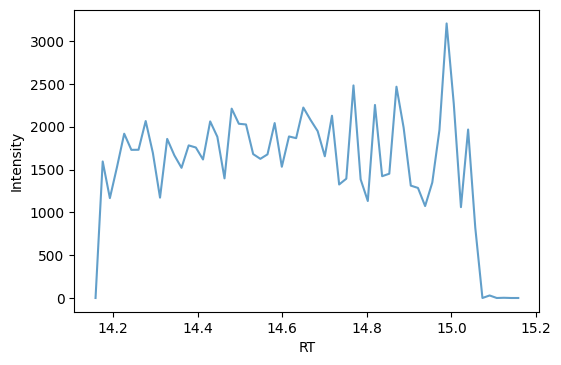

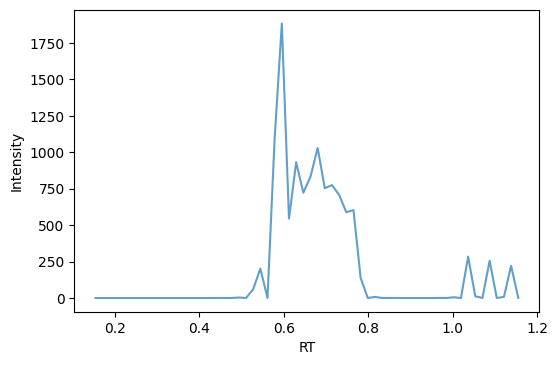

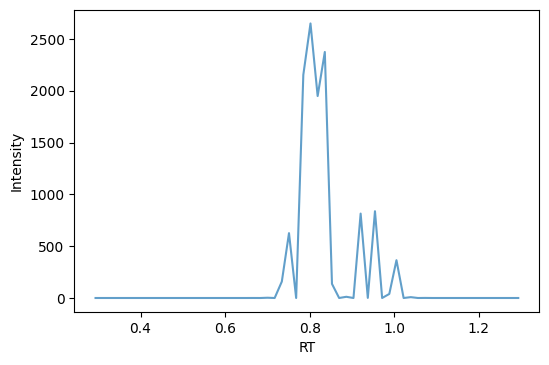

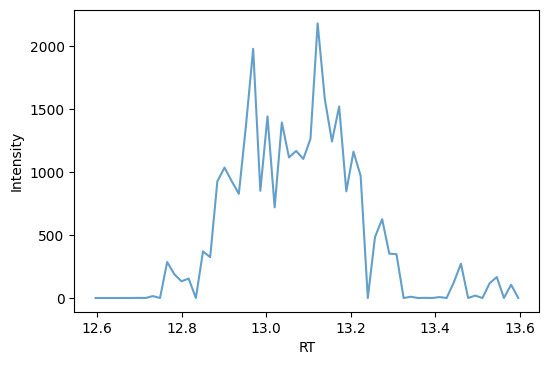

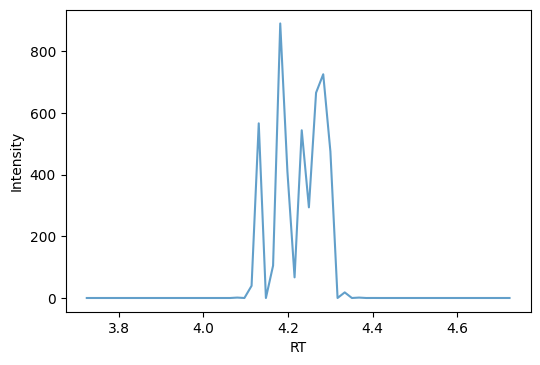

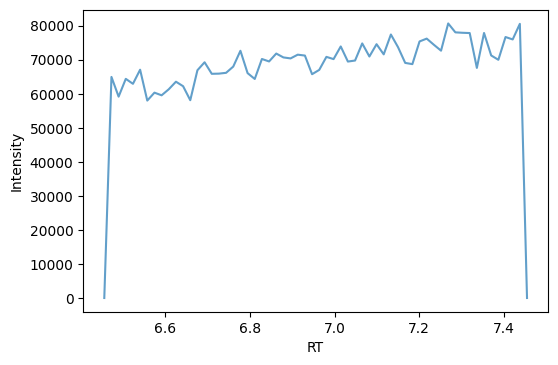

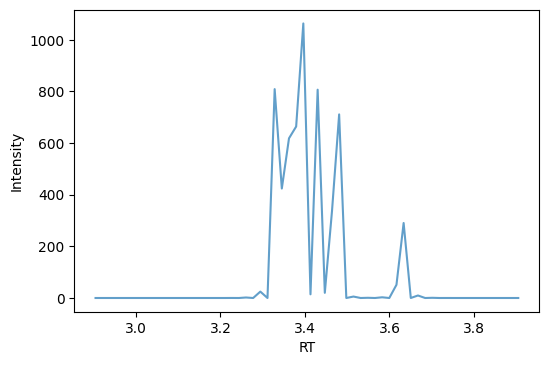

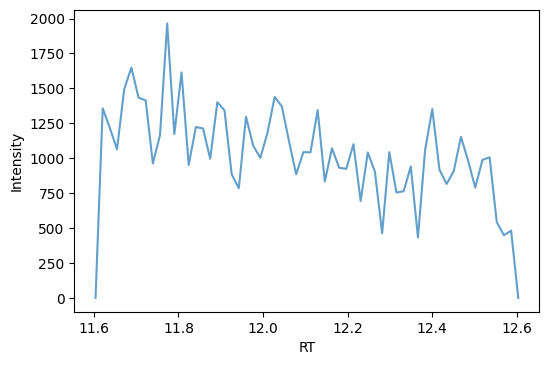

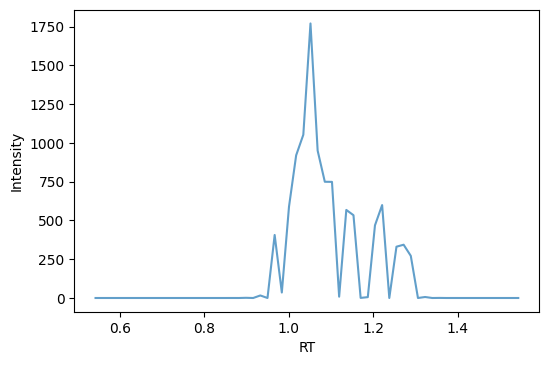

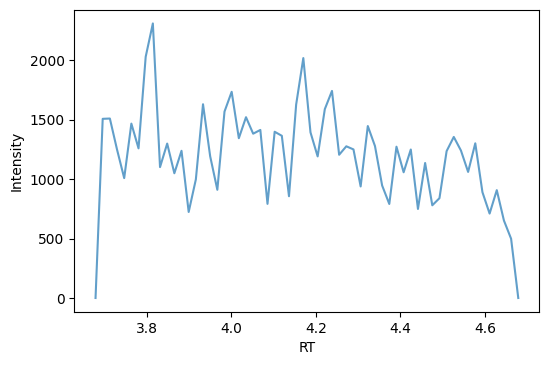

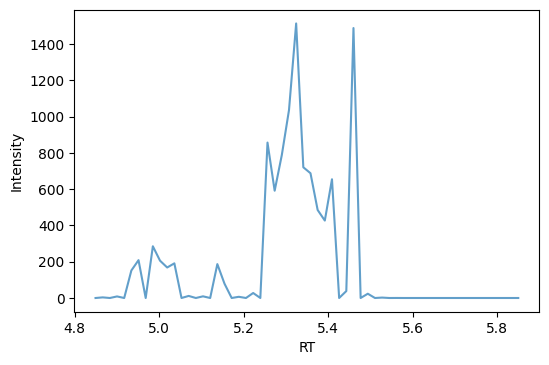

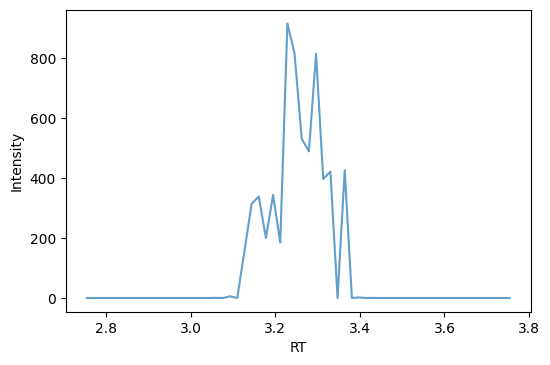

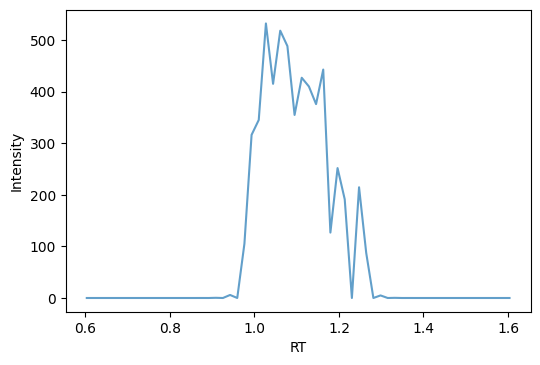

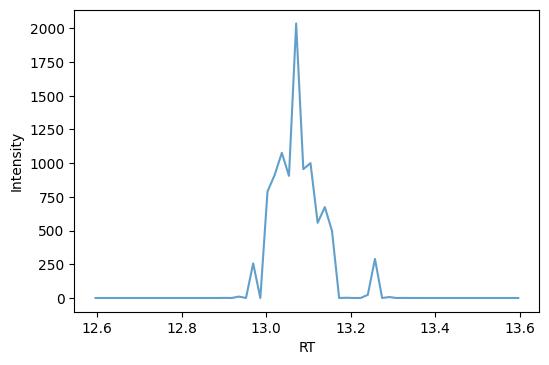

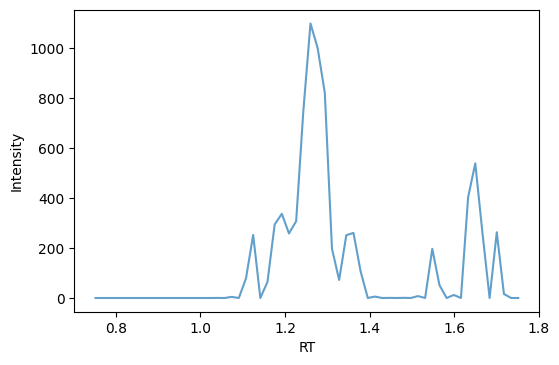

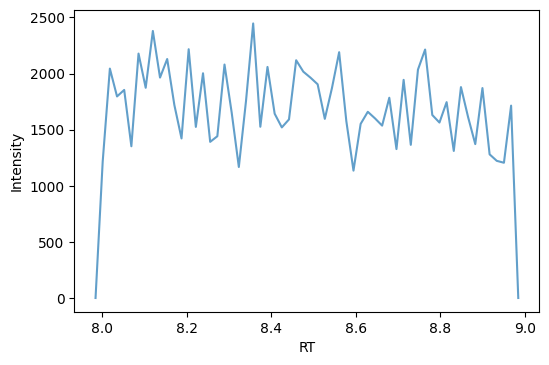

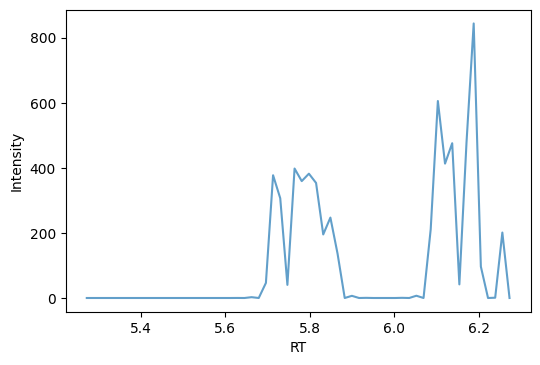

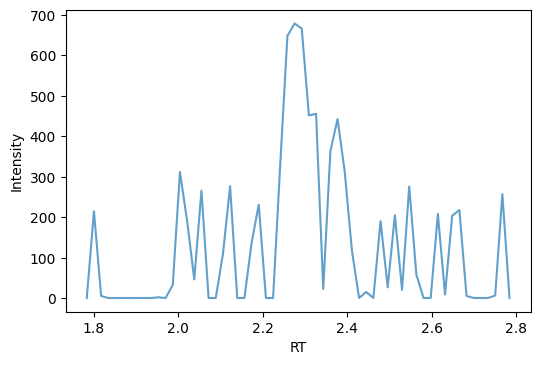

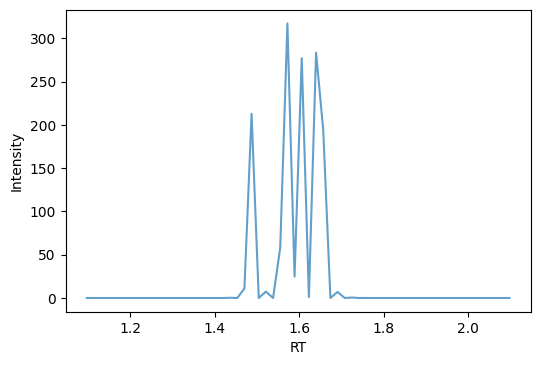

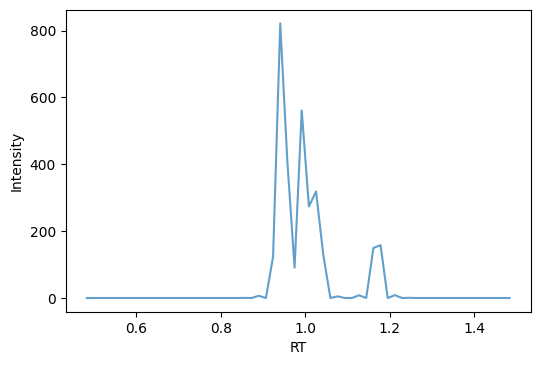

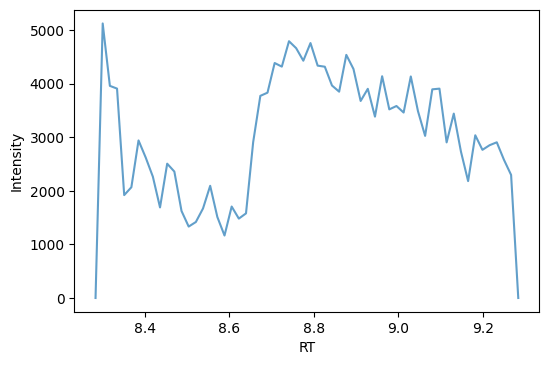

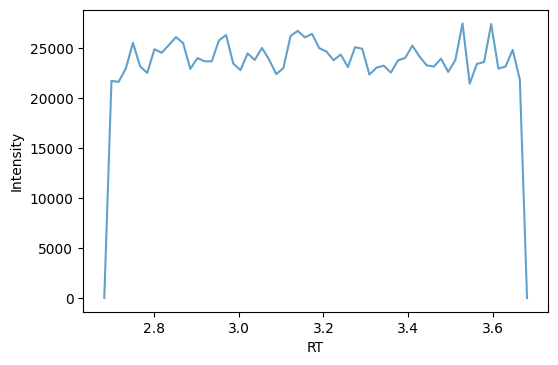

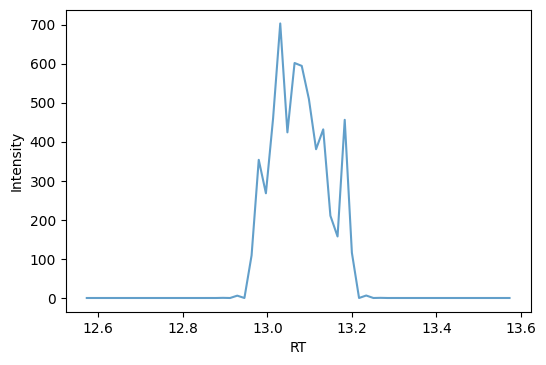

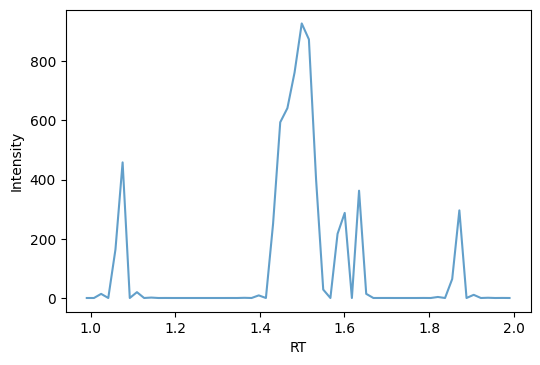

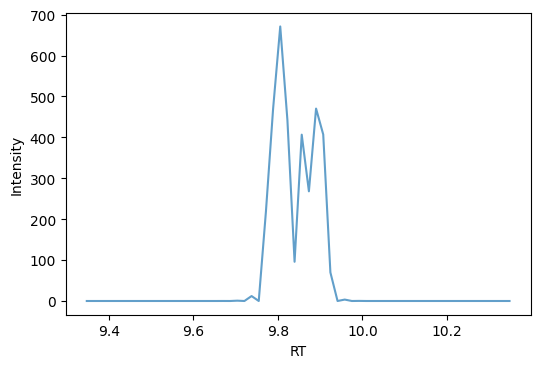

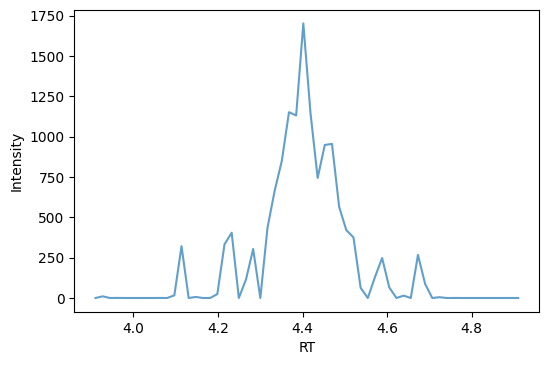

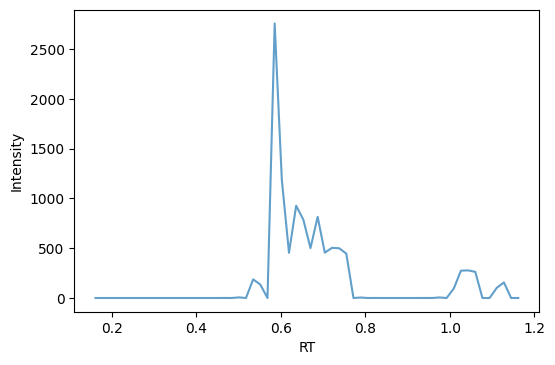

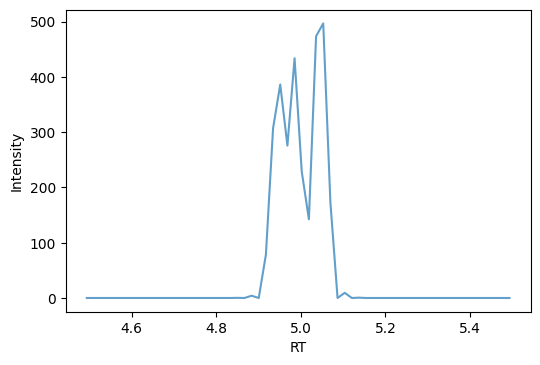

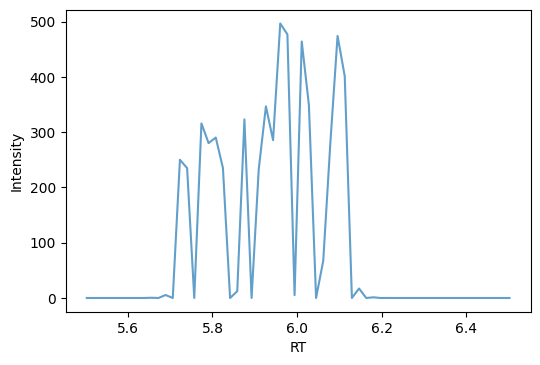

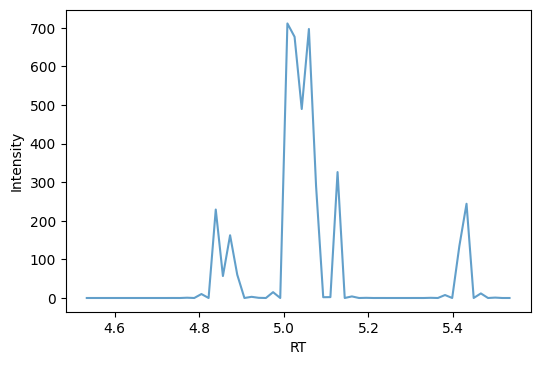

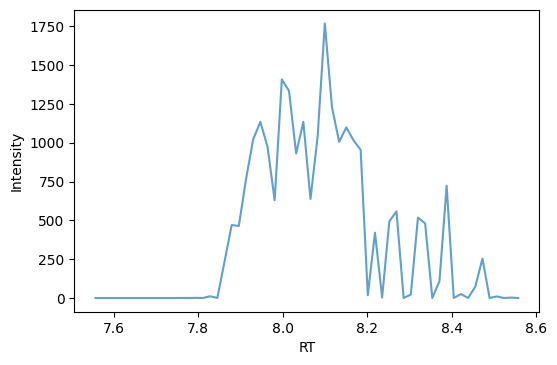

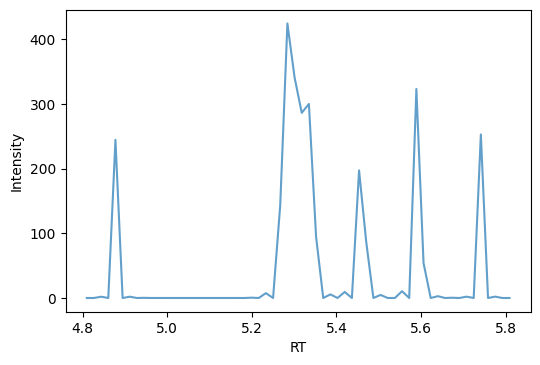

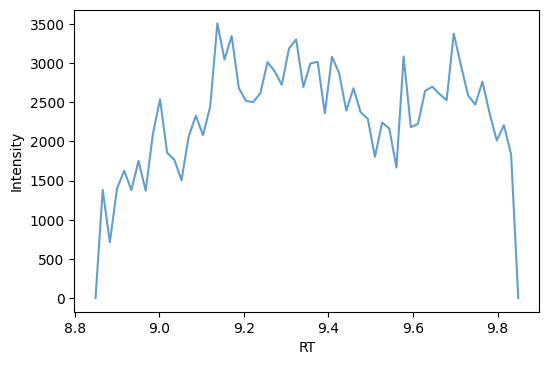

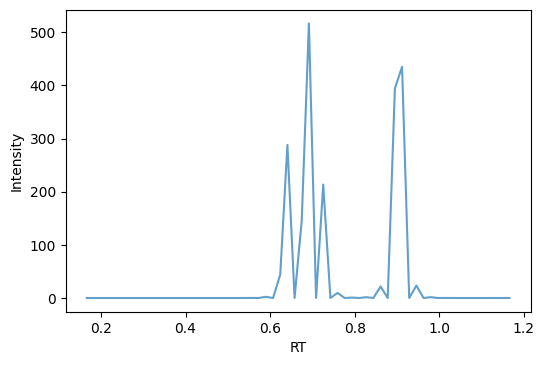

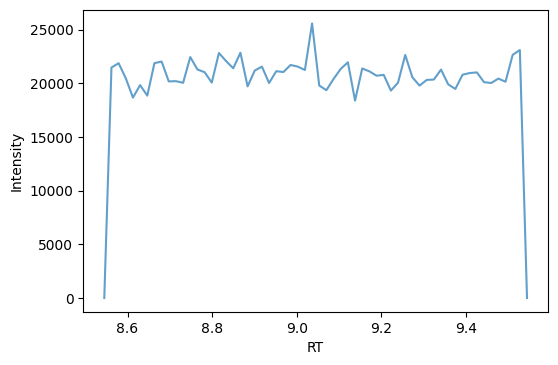

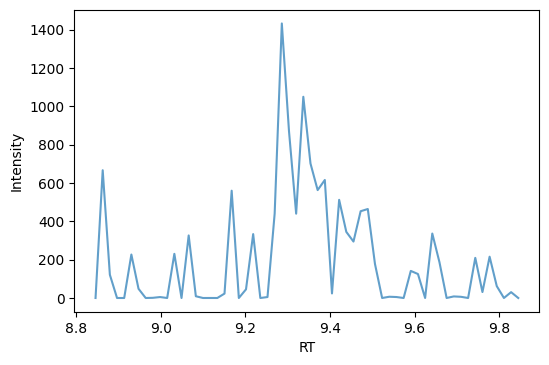

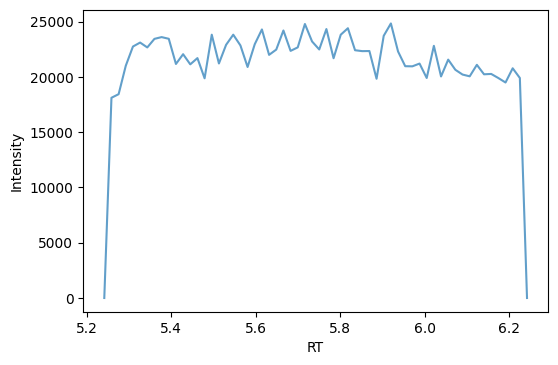

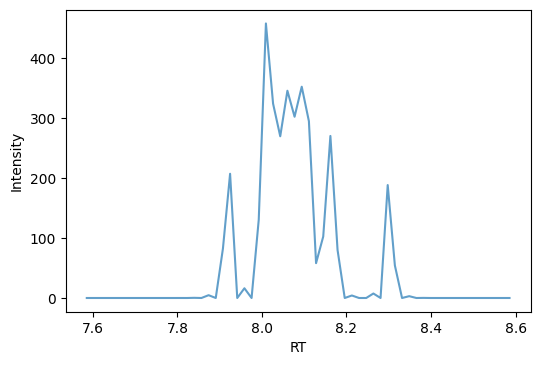

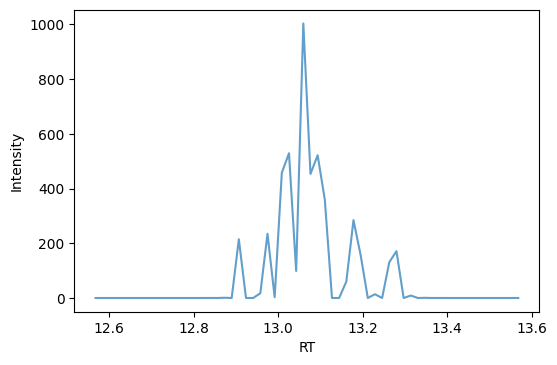

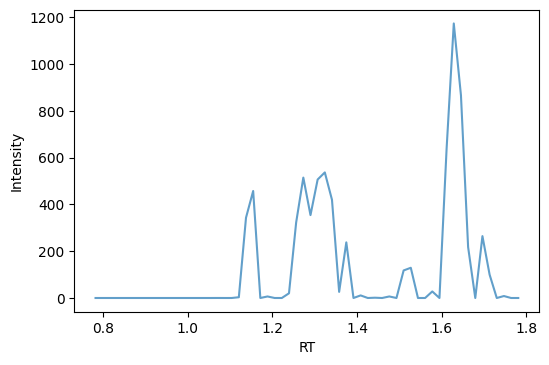

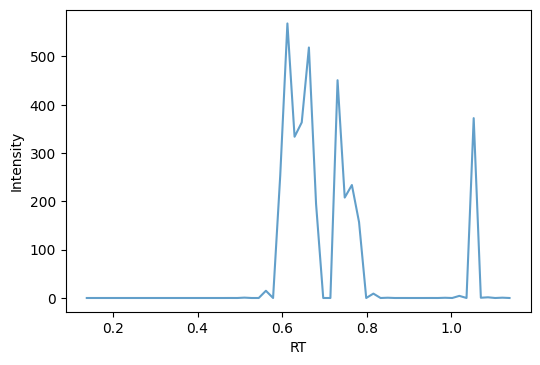

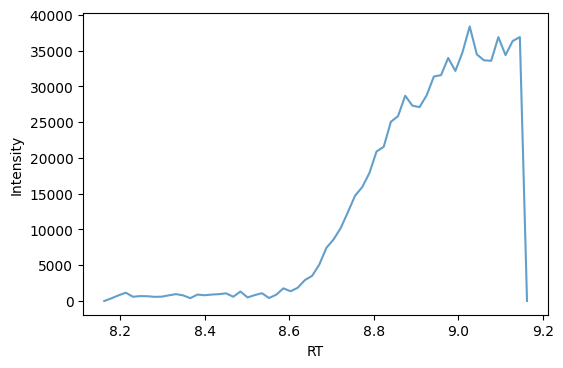

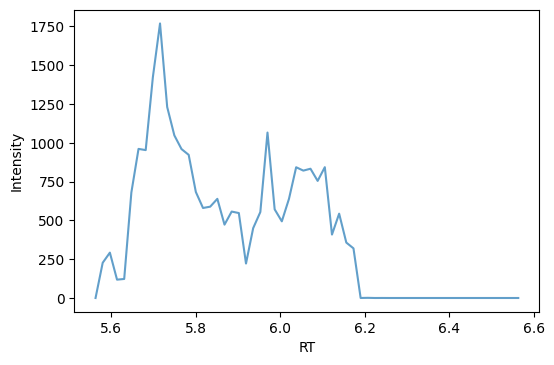

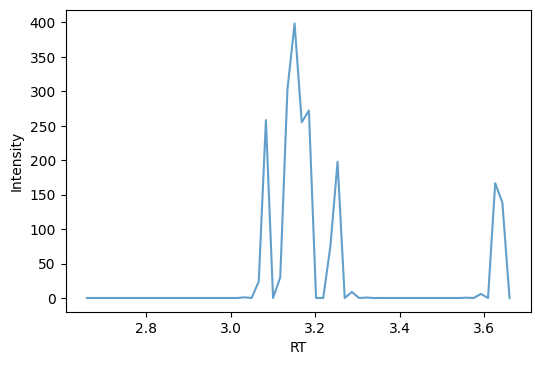

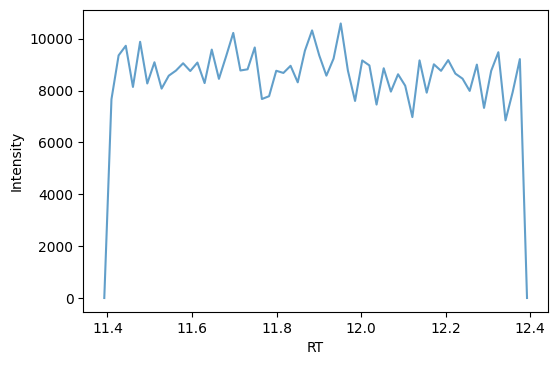

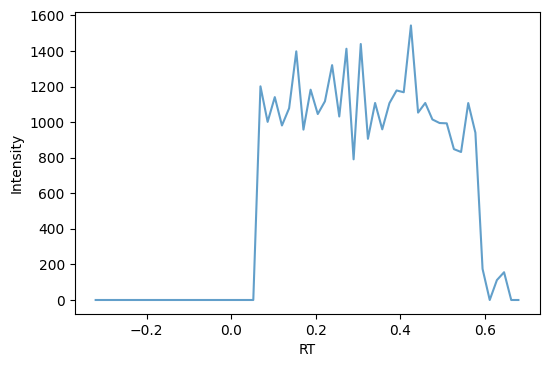

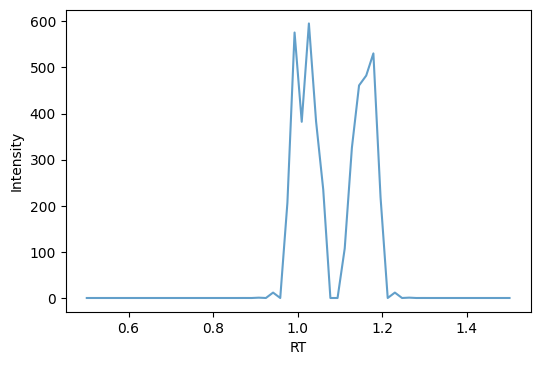

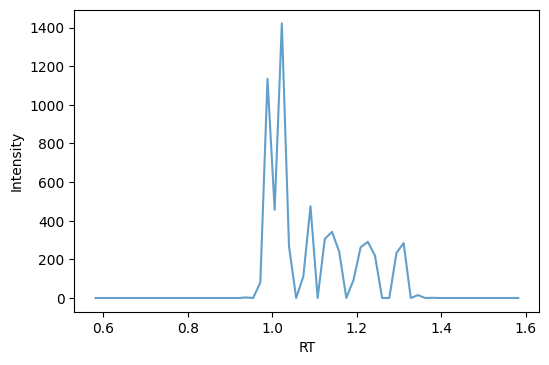

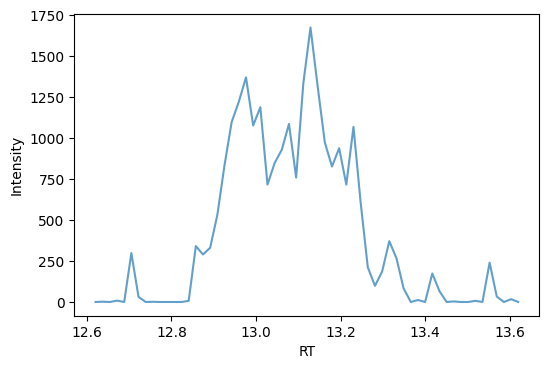

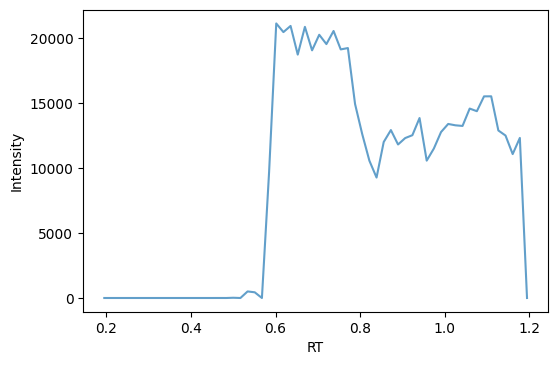

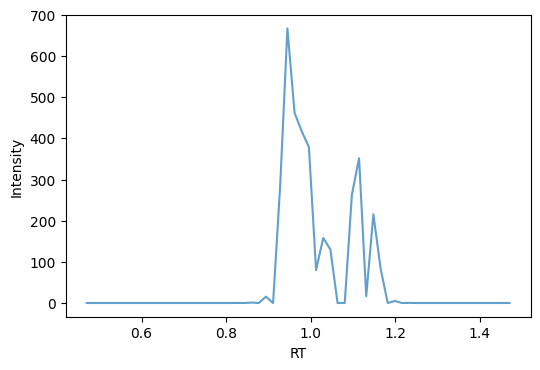

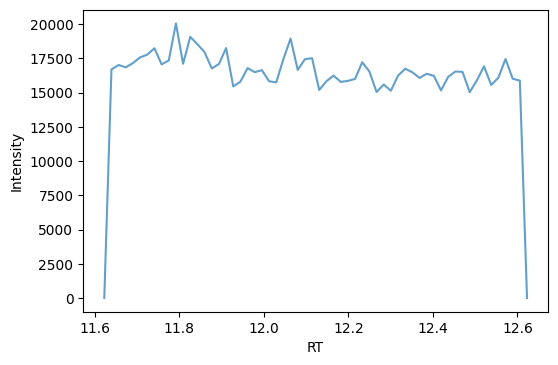

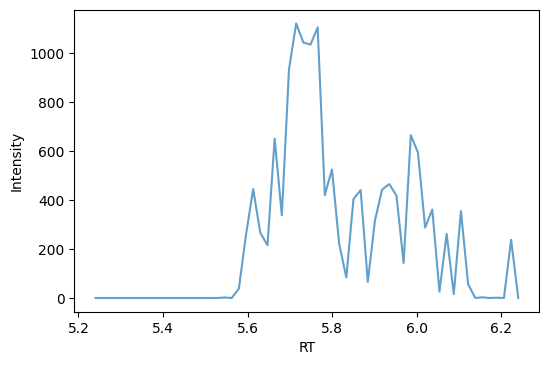

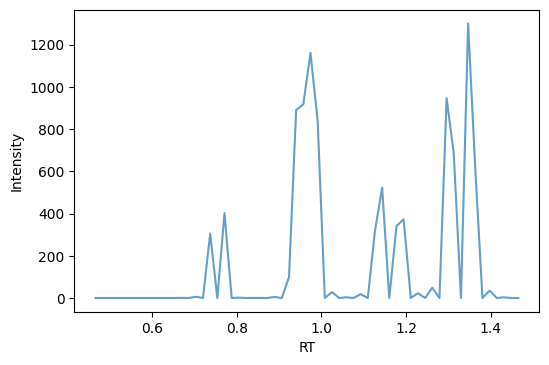

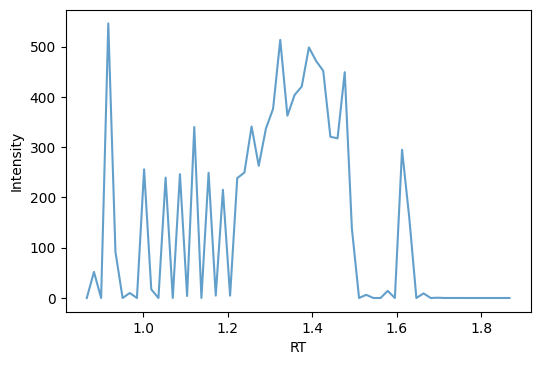

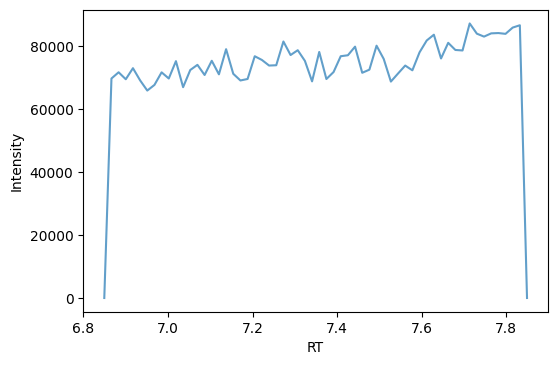

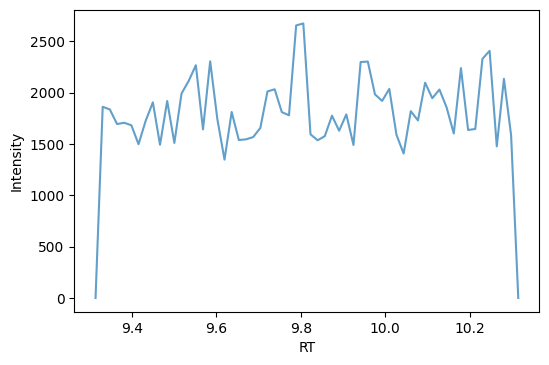

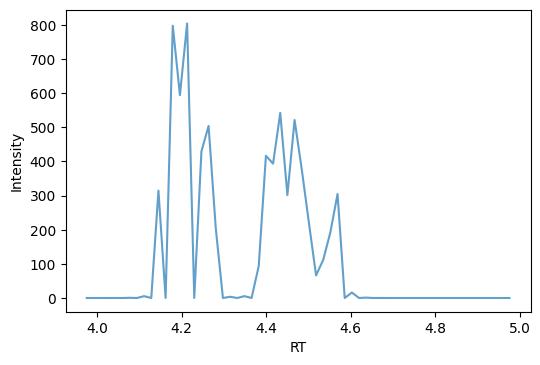

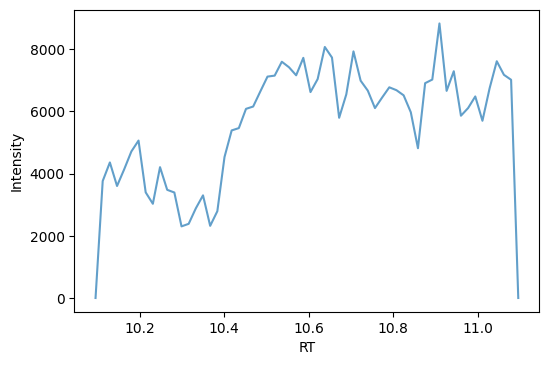

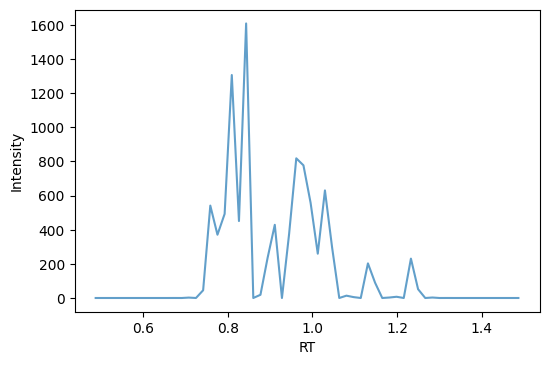

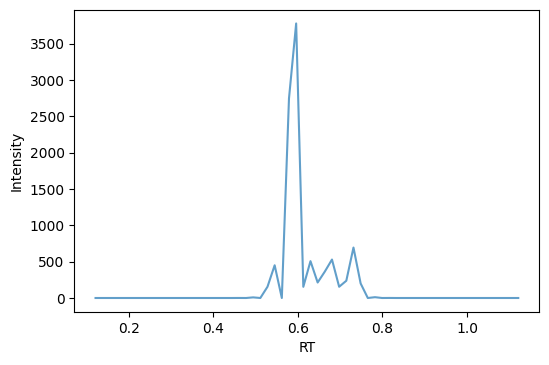

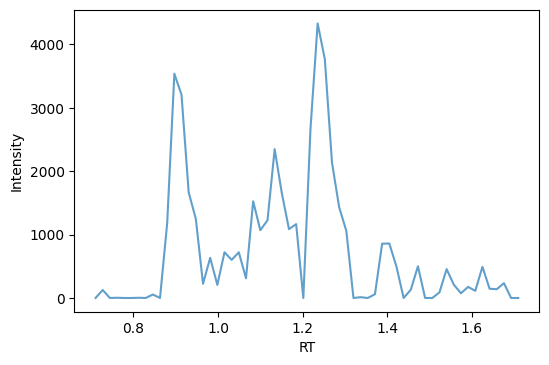

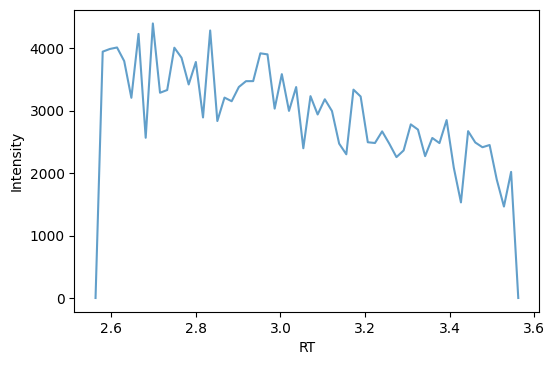

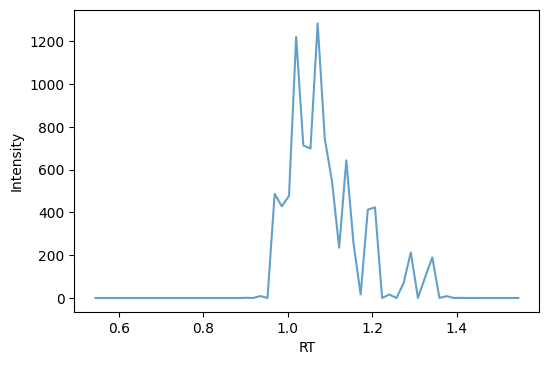

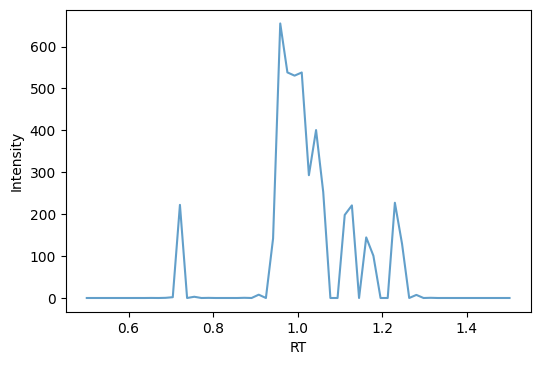

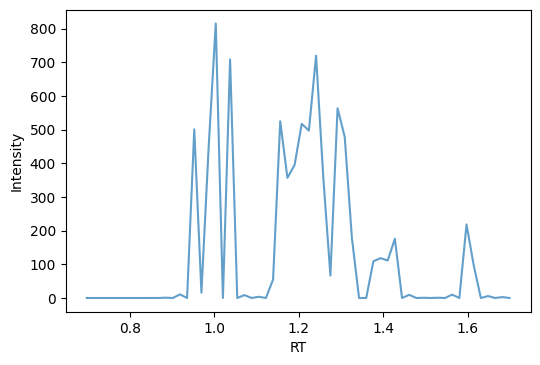

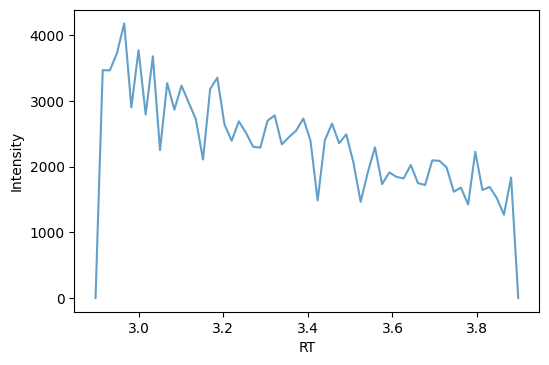

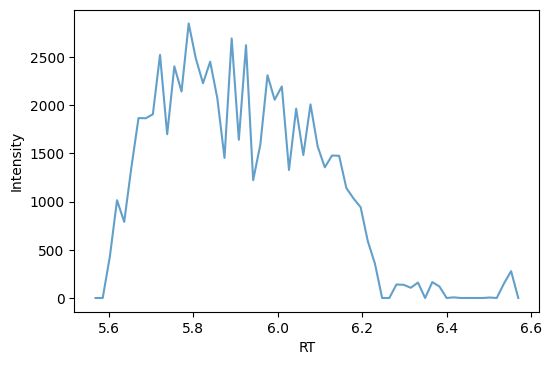

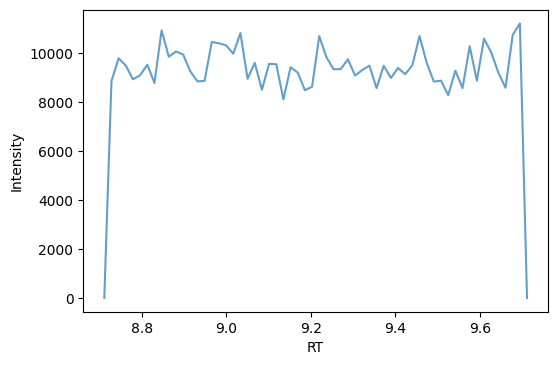

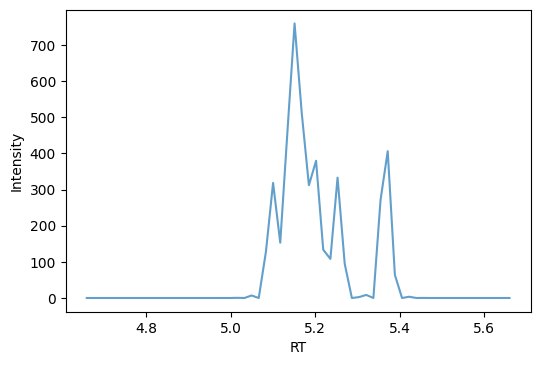

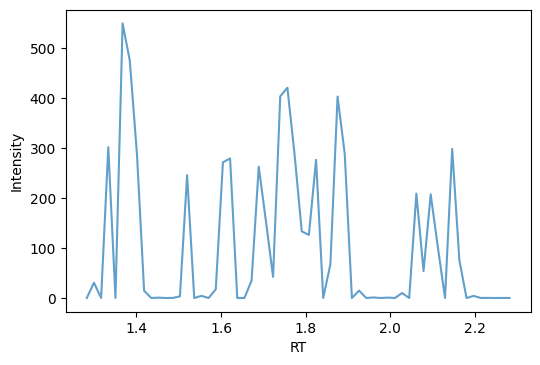

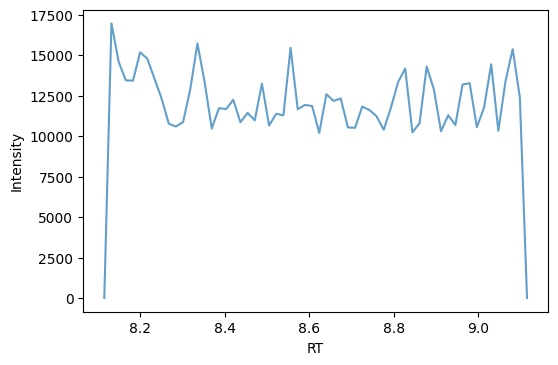

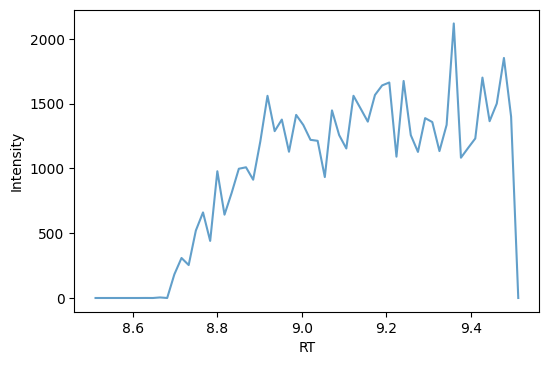

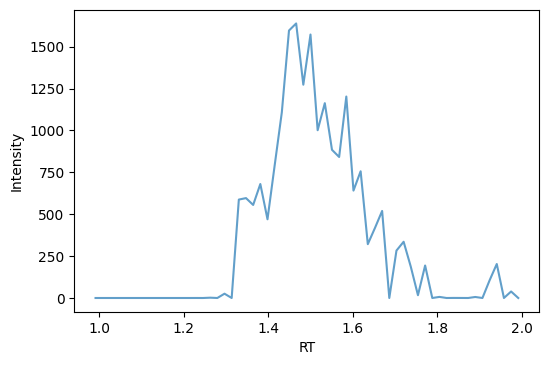

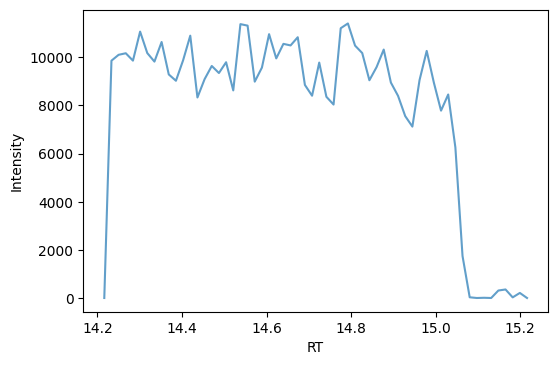

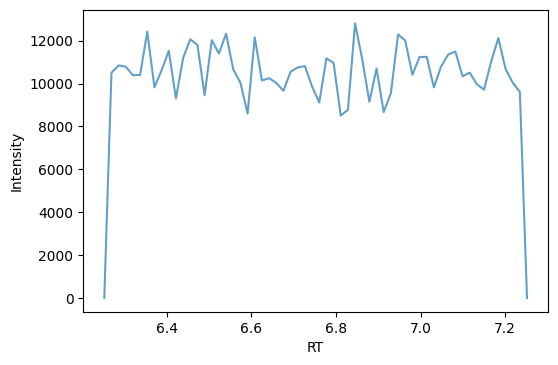

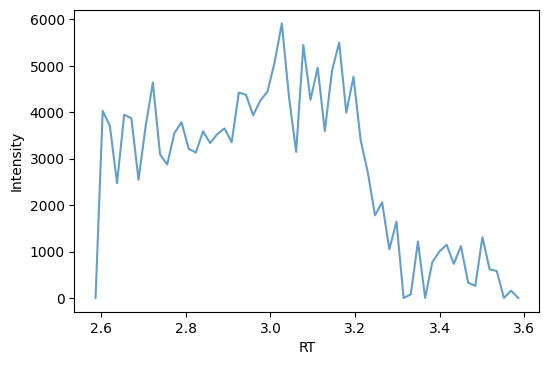

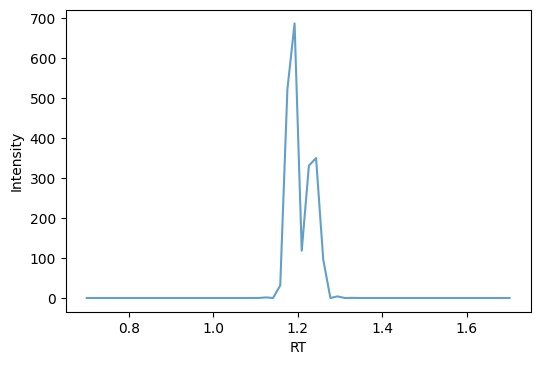

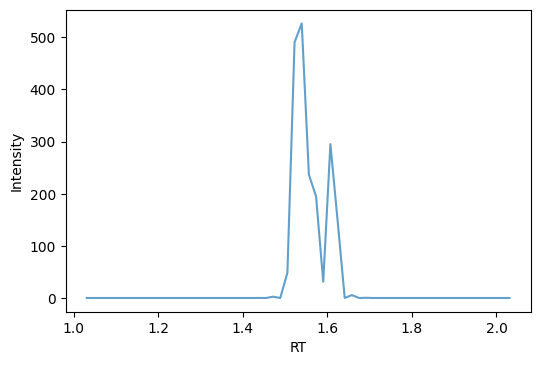

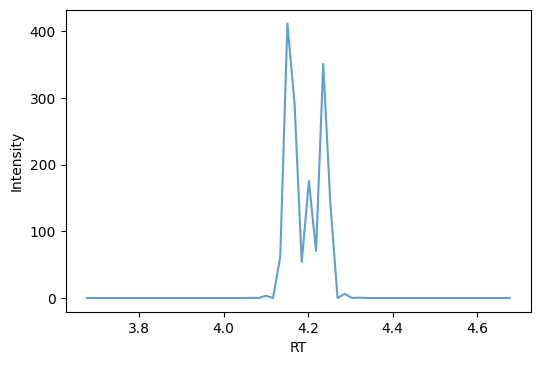

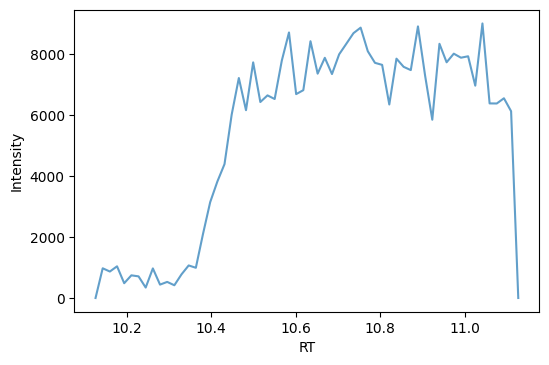

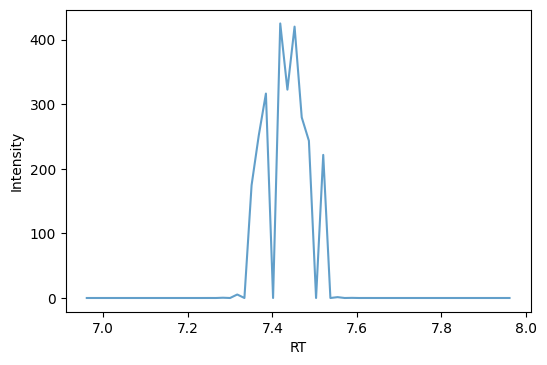

<Figure size 600x400 with 0 Axes>

In [37]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

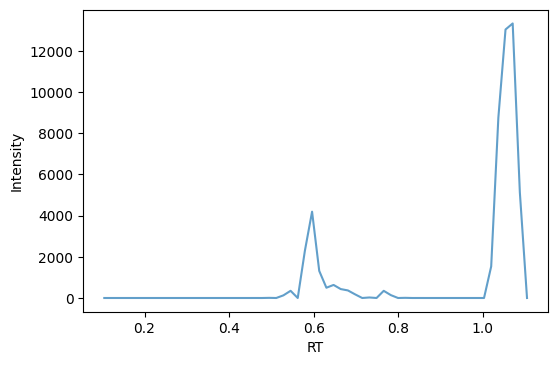

<Figure size 600x400 with 0 Axes>

In [38]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

0.6358

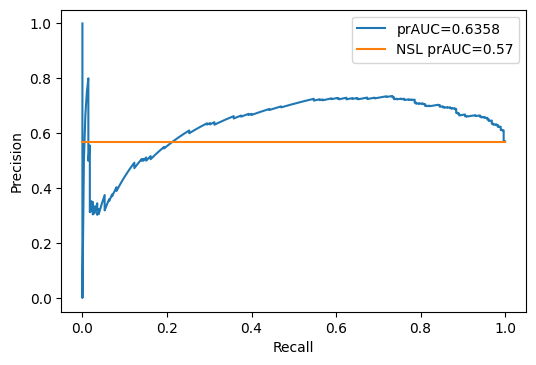

In [39]:
trueInt = []
predInt = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    predInt.append(peak_intensities.at[index,datadir+file])
    trueInt.append(row["classification"])

makePRCPlot(predInt,trueInt)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


0.7589

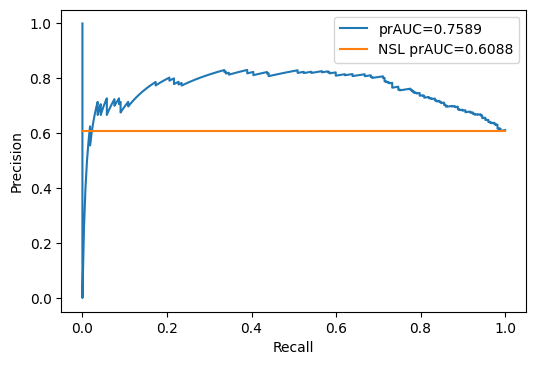

In [41]:
trueCV = []
predCV = []
for index,row in peakList_labeled.iterrows():
    ints = [peak_intensities.at[index,datadir+file] for file in files]
    cv = 1 - np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0:
        predCV.append(cv)
        trueCV.append(row["classification"])

makePRCPlot(predCV,trueCV)


0.7589

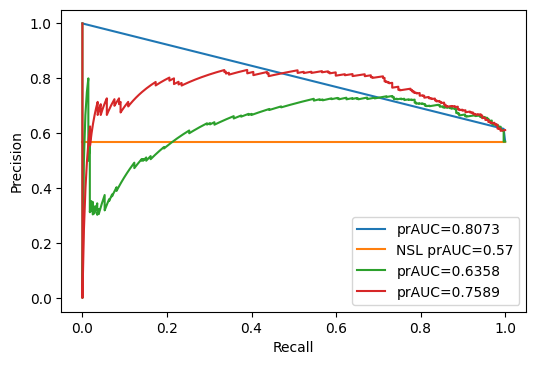

In [42]:
makePRCPlot(pred,true)
makePRCPlot(predInt,trueInt,False)
makePRCPlot(predCV,trueCV,False)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='classification', ylabel='CV'>

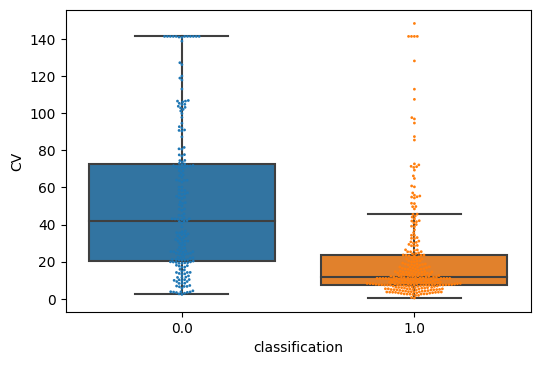

In [43]:
plt_df = {}
for index,row in peakList_labeled.iterrows():
    ints = [peak_intensities.at[index,datadir+file] for file in files]
    cv = 100 * np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0:
        plt_df[len(plt_df)] = {"classification":row["classification"],"CV":cv}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="CV",s=2)
sb.boxplot(data=plt_df,x="classification",y="CV",fliersize=0)

<AxesSubplot:xlabel='classification', ylabel='intensity'>

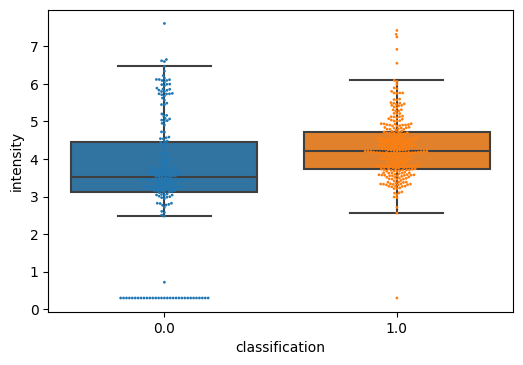

In [44]:
plt_df = {}
file = files[0]
np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X]))
for index,row in peakList_labeled.iterrows():
    plt_df[len(plt_df)] = {"classification":row["classification"],"intensity":np.log10(np.max([2,peak_intensities.at[index,datadir+file]]))}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="intensity",s=2)
sb.boxplot(data=plt_df,x="classification",y="intensity",fliersize=0)

<AxesSubplot:xlabel='classification', ylabel='Peak Score'>

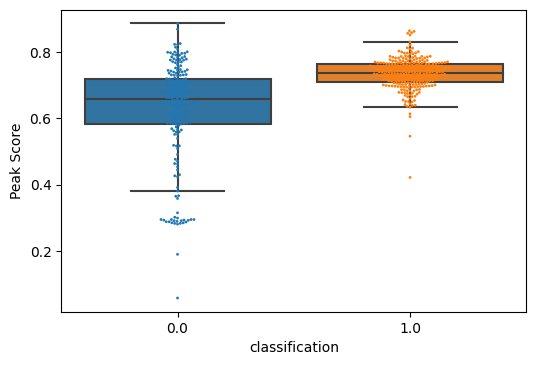

In [45]:
plt_df = {}
file = files[0]
for index,row in peakList_labeled.iterrows():
    plt_df[len(plt_df)] = {"classification":row["classification"],"Peak Score":peak_scores.at[index,datadir+file]}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="Peak Score",s=2)
sb.boxplot(data=plt_df,x="classification",y="Peak Score",fliersize=0)

In [46]:
skyline_peak_areas = pd.read_csv(datadir + "skyline_peak_areas.csv").fillna(0.0)
skyline_peak_areas

Molecule Name  Precursor Charge  Precursor Mz  Explicit Retention Time  \
0        unknown 1                -1     52.995274                     5.07   
1        unknown 2                -1     54.977012                     5.07   
2        unknown 3                -1     55.018832                     6.04   
3        unknown 4                -1     56.995900                    13.09   
4        unknown 5                -1     57.034581                     1.58   
...            ...               ...           ...                      ...   
3973  unknown 3974                -1   1612.976193                    12.74   
3974  unknown 3975                -1   1612.974722                     2.21   
3975  unknown 3976                -1   1613.977307                    14.98   
3976  unknown 3977                -1   1613.978101                     2.21   
3977  unknown 3978                -1   1613.978958                    12.72   

      B1_NIST1950_1_6540 Area  B1_NIST1950_2_6540 Area  \
0                         0.0                      0.0   
1                    149741.0                 118835.0   
2                      7339.0                   5864.0   
3                   6105351.0                5302879.0   
4                     25775.0                  21628.0   
...                       ...                      ...   
3973                   1690.0                   4027.0   
3974                   3309.0                  76403.0   
3975                   4898.0                  40031.0   
3976                   1855.0                  24080.0   
3977                   1854.0                    943.0   

      B1_NIST1950_3_6540 Area  
0                         0.0  
1                    117472.0  
2                      7837.0  
3                   5042084.0  
4                     16442.0  
...                       ...  
3973                    669.0  
3974                   1734.0  
3975                   3383.0  
3976                     44.0  
3977                   8655.0  

[3978 rows x 7 columns]

In [47]:
data_mat_peak_areas_skyline = skyline_peak_areas[skyline_peak_areas.columns.values[4:]].values
data_mat_peak_areas_skyline.shape

(3978, 3)

In [48]:
peak_intensities

mz         rt  ../data/covid_plasma/B1_NIST1950_1_6540.mzML  \
1       52.995274   5.074233                                  0.000000e+00   
2       54.977012   5.074233                                  1.379597e+05   
3       55.018832   6.038233                                  2.614126e+03   
4       56.995900  13.087117                                  5.008748e+06   
5       57.034581   1.584267                                  1.841325e+04   
...           ...        ...                                           ...   
3974  1612.976193  12.735550                                  8.198740e+03   
3975  1612.974722   2.214650                                  1.181902e+04   
3976  1613.977307  14.982067                                  2.652394e+03   
3977  1613.978101   2.214650                                  2.456033e+02   
3978  1613.978958  12.718933                                  5.738912e+03   

      ../data/covid_plasma/B1_NIST1950_2_6540.mzML  \
1                                     0.000000e+00   
2                                     1.058572e+05   
3                                     4.649819e+03   
4                                     4.108130e+06   
5                                     1.813873e+04   
...                                            ...   
3974                                  1.054114e+05   
3975                                  6.946844e+04   
3976                                  1.273110e+04   
3977                                  2.527240e+04   
3978                                  1.305602e+04   

      ../data/covid_plasma/B1_NIST1950_3_6540.mzML  
1                                     0.000000e+00  
2                                     1.038218e+05  
3                                     4.437179e+03  
4                                     4.011063e+06  
5                                     1.296935e+04  
...                                            ...  
3974                                 -4.483487e+02  
3975                                  1.512852e+04  
3976                                  4.922531e+03  
3977                                  0.000000e+00  
3978                                  4.779079e+03  

[3978 rows x 5 columns]

In [49]:
peak_areas_peak_detective = peak_intensities[peak_intensities.columns.values[2:]].values
peak_areas_peak_detective.shape

(3978, 3)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


0.12237545324578292

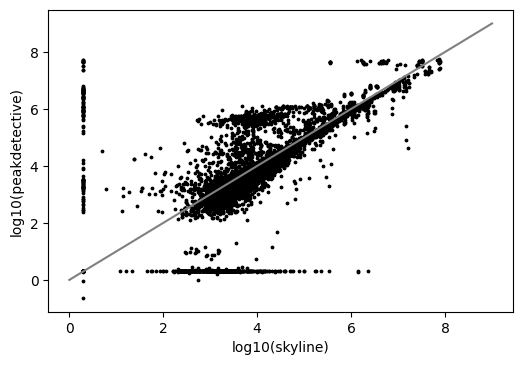

In [50]:
plt.scatter(np.log10(data_mat_peak_areas_skyline.flatten()+2),np.log10(peak_areas_peak_detective.flatten() + 2),color="black",s=3)
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(skyline)")
plt.ylabel("log10(peakdetective)")
met.r2_score(data_mat_peak_areas_skyline.flatten(),peak_areas_peak_detective.flatten())